<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, msa_flagging step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and msa_flagging validation tests](#pipeline_ID): [MOS test](#MOS), [IFU test](#IFU) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

os.chdir(data_dir.name)

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing the NIRSpec Pipeline Testing Tool.

* os for filepaths
* subprocess for installing NPTT and moving output files
* astropy.io for opening fits files
* jwst.msaflagopen.msaflagopen_step is the pipeline step being tested

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install NPTT (https://github.com/spacetelescope/nirspec_pipe_testing_tool). 

If the installation is successful, you will be able to import NPTT.

[Top of Page](#title_ID)

In [3]:
import warnings
import psutil
from astropy.io import fits

# Only print a DeprecationWarning the first time it shows up, not every time.
with warnings.catch_warnings():
    warnings.simplefilter("once", category=DeprecationWarning)
    import jwst
    from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
    from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
    from jwst.msaflagopen.msaflagopen_step import MSAFlagOpenStep
    from jwst import datamodels

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata


In [4]:
# Make sure that the version used is the right one

pipeline_version = jwst.__version__
nptt_version = nptt.__version__

print("Using jwst pipeline version: ", pipeline_version)
print("Using NPTT version: ", nptt_version)

Using jwst pipeline version:  1.7.2
Using NPTT version:  2.0.1


<a id="intro_ID"></a>
# Test Description

The test is a comparison of the result of our implementation of the MSA Failed Open Flagging step algorithm versus the pipeline's implementation.

The overlap between the pixels flagged as being affected by failed open shutters are compared in regions large enough in the spectral direction to account for the non-repeatable motion of the grating wheel (a few pixels).

For the test to be considered PASSED, the overlap between the results of the two methods should be greater than or equal to msa_flagging_threshold percent for all failed open shutters affecting more than 100 pixels.

The code for these Multi Object Spectroscopy (MOS) and Integral Field Unit (IFU) tests can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/msa_flagging_testing.py. This pipeline step and the associated pytests are skipped if data is Fixed Slits (FS) or Bright Object Time Series (BOTS).

The input file is defined in the variable ```input_file``` (see section [Testing Data Set and Variable Setup](#data_ID)).

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/msaflagopen/index.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/msaflagopen


### Results

If the test **PASSED** this means that all slitlets or slices individually passed the test. However, if ony one individual slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+MSA+Failed+Open+Flagging


### Defining Terms
Acronymns used in this notebook:

pipeline: calibration pipeline

cal_detector1: calibration pipeline Stage 1, detector processing

spec2: calibration pipeline spectroscopic Stage 2, spectroscopic processing

NPTT: NIRSpec Pipeline Testing Tool


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and msa_flagging validation tests

The pipeline can be run from the command line in two variants: full or per step.

To run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

where jwtest_rate.fits is the output of cal_detector1.

To only run the msa_flagging step, use the command:

$ strun jwst.msaflagopen.msaflagopen_step jwtest_assign_wcs.fits

where jwtest_assign_wcs.fits is the output of the previous step, assign_wcs.

NIRSpec TA data will be run through the calwebb_detector1 and the imaging2 pipelines. The imaging pipeline can be run with the following command:

$ strun jwst.pipeline.Image2Pipeline jwtest_rate.fits

These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.msaflagopen.msaflagopen_step import msaflagopen_step
 
$\gt$ msaflagopen_step.call(jwtest_rate.fits)

For the imaging pipeline the call would be as follows:

$\gt$ from jwst.pipeline.calwebb_image2 import Image2Pipeline

$\gt$ Image2Pipeline.call(jwtest_rate.fits)

NPTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use NPTT to run the pipeline and the validation tests. To run NPTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used for testing:
- MOS_G140M_LINE1


[Top of Page](#title_ID)

In [5]:
testing_data = {                
                'mos_g140m_f100lp':{
                                  'uncal_file_nrs1': 'mos_g140m_line1_NRS1_uncal.fits',
                                  'uncal_file_nrs2': 'mos_g140m_line1_NRS2_uncal.fits',  
                                  'msa_shutter_config': 'V8460001000101_msa.fits' }
               }



In [6]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data

Testing files for detector:  nrs1


Working with uncal_file:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki/mos_g140m_line1_NRS1_uncal.fits


2022-10-06 00:37:13,963 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2022-10-06 00:37:13,995 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-06 00:37:13,997 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-06 00:37:13,998 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-06 00:37:13,999 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-06 00:37:14,000 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-06 00:37:14,001 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-06 00:37:14,002 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-06 00:37:14,004 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-06 00:37:14,005 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-06 00:37:14,006 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-06 00:37:14,007 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-06 00:37:14,008 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-06 00:37:14,010 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-06 00:37:14,011 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-06 00:37:14,012 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-06 00:37:14,013 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-06 00:37:14,014 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-06 00:37:14,169 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki/mos_g140m_line1_NRS1_uncal.fits',).


2022-10-06 00:37:14,179 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-10-06 00:37:14,366 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'mos_g140m_line1_NRS1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-06 00:37:14,377 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0140.fits'.


2022-10-06 00:37:14,379 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits'.


2022-10-06 00:37:14,381 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0019.fits'.


2022-10-06 00:37:14,382 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0024.fits'.


2022-10-06 00:37:14,384 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-06 00:37:14,384 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0019.fits'.


2022-10-06 00:37:14,386 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-10-06 00:37:14,387 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-06 00:37:14,387 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-10-06 00:37:14,388 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0023.fits'.


2022-10-06 00:37:14,389 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0087.fits'.


2022-10-06 00:37:14,391 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-06 00:37:14,391 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-06 00:37:14,392 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-06 00:37:14,791 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:37:14,793 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki'}


2022-10-06 00:37:14,929 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-10-06 00:37:14,930 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-06 00:37:14,932 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-06 00:37:15,074 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:37:15,076 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki'}


2022-10-06 00:37:15,099 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0024.fits


2022-10-06 00:37:15,510 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-06 00:37:15,647 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:37:15,649 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki', 'n_pix_grow_sat': 1}


2022-10-06 00:37:15,672 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0023.fits


2022-10-06 00:37:17,459 - stpipe.Detector1Pipeline.saturation - INFO - Detected 108240 saturated pixels


2022-10-06 00:37:17,483 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-06 00:37:17,498 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-06 00:37:17,653 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:37:17,654 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki'}


2022-10-06 00:37:17,655 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-06 00:37:17,658 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-06 00:37:17,802 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:37:17,803 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki'}


2022-10-06 00:37:17,828 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0087.fits


2022-10-06 00:37:18,359 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-10-06 00:37:18,509 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:37:18,511 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-06 00:37:18,643 - stpipe.Detector1Pipeline.refpix - INFO - NIR full frame data


2022-10-06 00:37:18,644 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are valid for this mode:


2022-10-06 00:37:18,644 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-10-06 00:37:18,645 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-10-06 00:37:18,645 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-10-06 00:37:18,646 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-10-06 00:37:18,646 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is not applicable and is ignored:


2022-10-06 00:37:18,646 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = False


2022-10-06 00:37:21,126 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-06 00:37:21,278 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:37:21,280 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki'}


2022-10-06 00:37:21,304 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0019.fits


2022-10-06 00:37:24,918 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-06 00:37:25,105 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:37:25,106 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki', 'dark_output': None}


2022-10-06 00:37:25,130 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0140.fits


2022-10-06 00:37:26,464 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=6, nframes=1, groupgap=0


2022-10-06 00:37:26,465 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=10, nframes=1, groupgap=0


2022-10-06 00:37:26,773 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-06 00:37:26,965 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:37:26,967 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-06 00:37:26,977 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-06 00:37:26,991 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2022-10-06 00:37:27,155 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0019.fits


2022-10-06 00:37:27,555 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-06 00:37:27,618 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
2022-10-06 00:37:29,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41569 pixels with at least one CR from five or more groups.


2022-10-06 00:37:29,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2712 pixels with at least one CR from four groups.


2022-10-06 00:37:29,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3136 pixels with at least one CR from three groups.


2022-10-06 00:37:36,743 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.18645 sec


2022-10-06 00:37:36,747 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.770020


2022-10-06 00:37:36,753 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-06 00:37:36,960 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:37:36,961 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-06 00:37:36,997 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0019.fits


2022-10-06 00:37:36,997 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2022-10-06 00:37:37,112 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-06 00:37:37,113 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-10-06 00:38:01,959 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 6


2022-10-06 00:38:01,960 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-10-06 00:38:02,139 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-06 00:38:02,379 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:38:02,380 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki'}


2022-10-06 00:38:02,462 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 00:38:02,463 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 00:38:02,468 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 00:38:02,613 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:38:02,614 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki'}


2022-10-06 00:38:02,683 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 00:38:02,684 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 00:38:02,688 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 00:38:02,689 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-06 00:38:02,689 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:38:02,690 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-06 00:38:02,699 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-06 00:38:02,842 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:38:02,843 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


Using MSA shutter config:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki/V8460001000101_msa.fits


2022-10-06 00:38:03,004 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1


2022-10-06 00:38:03,226 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2022-10-06 00:38:03,226 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2022-10-06 00:38:03,227 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg


2022-10-06 00:38:03,229 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:38:03,468 - stpipe.AssignWcsStep - INFO - Removing slit 6 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,481 - stpipe.AssignWcsStep - INFO - Removing slit 7 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,493 - stpipe.AssignWcsStep - INFO - Removing slit 8 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,505 - stpipe.AssignWcsStep - INFO - Removing slit 9 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,517 - stpipe.AssignWcsStep - INFO - Removing slit 10 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,529 - stpipe.AssignWcsStep - INFO - Removing slit 11 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,542 - stpipe.AssignWcsStep - INFO - Removing slit 14 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,554 - stpipe.AssignWcsStep - INFO - Removing slit 15 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,566 - stpipe.AssignWcsStep - INFO - Removing slit 16 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,578 - stpipe.AssignWcsStep - INFO - Removing slit 17 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,590 - stpipe.AssignWcsStep - INFO - Removing slit 18 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,602 - stpipe.AssignWcsStep - INFO - Removing slit 19 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,614 - stpipe.AssignWcsStep - INFO - Removing slit 21 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,626 - stpipe.AssignWcsStep - INFO - Removing slit 25 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,639 - stpipe.AssignWcsStep - INFO - Removing slit 26 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,651 - stpipe.AssignWcsStep - INFO - Removing slit 27 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,663 - stpipe.AssignWcsStep - INFO - Removing slit 29 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,675 - stpipe.AssignWcsStep - INFO - Removing slit 31 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,687 - stpipe.AssignWcsStep - INFO - Removing slit 32 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,699 - stpipe.AssignWcsStep - INFO - Removing slit 33 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,711 - stpipe.AssignWcsStep - INFO - Removing slit 35 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,724 - stpipe.AssignWcsStep - INFO - Removing slit 37 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,736 - stpipe.AssignWcsStep - INFO - Removing slit 38 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,748 - stpipe.AssignWcsStep - INFO - Removing slit 39 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,760 - stpipe.AssignWcsStep - INFO - Removing slit 41 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,795 - stpipe.AssignWcsStep - INFO - Removing slit 1 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,806 - stpipe.AssignWcsStep - INFO - Removing slit 2 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,819 - stpipe.AssignWcsStep - INFO - Removing slit 3 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,831 - stpipe.AssignWcsStep - INFO - Removing slit 4 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,843 - stpipe.AssignWcsStep - INFO - Removing slit 5 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,855 - stpipe.AssignWcsStep - INFO - Removing slit 12 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,867 - stpipe.AssignWcsStep - INFO - Removing slit 13 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,879 - stpipe.AssignWcsStep - INFO - Removing slit 20 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,891 - stpipe.AssignWcsStep - INFO - Removing slit 22 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,903 - stpipe.AssignWcsStep - INFO - Removing slit 23 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,915 - stpipe.AssignWcsStep - INFO - Removing slit 24 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,927 - stpipe.AssignWcsStep - INFO - Removing slit 28 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,939 - stpipe.AssignWcsStep - INFO - Removing slit 30 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,951 - stpipe.AssignWcsStep - INFO - Removing slit 34 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,963 - stpipe.AssignWcsStep - INFO - Removing slit 36 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:03,975 - stpipe.AssignWcsStep - INFO - Removing slit 40 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:04,261 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS1: [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]


2022-10-06 00:38:04,262 - stpipe.AssignWcsStep - INFO - Computing WCS for 27 open slitlets


2022-10-06 00:38:04,298 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2022-10-06 00:38:04,298 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2022-10-06 00:38:04,299 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg


2022-10-06 00:38:04,300 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:38:04,313 - stpipe.AssignWcsStep - INFO - SPORDER= -1, wrange=[9.7e-07, 1.89e-06]


2022-10-06 00:38:04,458 - stpipe.AssignWcsStep - INFO - There are 2 open slits in quadrant 1


2022-10-06 00:38:04,474 - stpipe.AssignWcsStep - INFO - There are 11 open slits in quadrant 2


2022-10-06 00:38:04,557 - stpipe.AssignWcsStep - INFO - There are 4 open slits in quadrant 3


2022-10-06 00:38:04,588 - stpipe.AssignWcsStep - INFO - There are 10 open slits in quadrant 4


2022-10-06 00:38:04,833 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5


2022-10-06 00:38:05,000 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0032.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0023.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafile': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki/V8460001000101_msa.fits'}


2022-10-06 00:38:05,878 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-10-06 00:38:05,892 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:38:05,893 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-10-06 00:38:05,903 - stpipe.MSAFlagOpenStep - INFO - MSAFlagOpenStep instance created.


2022-10-06 00:38:06,089 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:38:06,091 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 00:38:06,108 - stpipe.MSAFlagOpenStep - INFO - Using reference file /grp/crds/cache/references/jwst/jwst_nirspec_msaoper_0001.json


2022-10-06 00:38:06,109 - stpipe.JwstStep - INFO - JwstStep instance created.


2022-10-06 00:38:06,245 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2022-10-06 00:38:06,246 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2022-10-06 00:38:06,247 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: 0.0002496099796717191 deg


2022-10-06 00:38:06,248 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:38:06,261 - stpipe.MSAFlagOpenStep - INFO - SPORDER= -1, wrange=[9.7e-07, 1.89e-06]


2022-10-06 00:38:06,406 - stpipe.MSAFlagOpenStep - INFO - There are 5 open slits in quadrant 1


2022-10-06 00:38:06,443 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 2


2022-10-06 00:38:06,466 - stpipe.MSAFlagOpenStep - INFO - There are 9 open slits in quadrant 3


2022-10-06 00:38:06,534 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 4


2022-10-06 00:38:06,557 - stpipe.MSAFlagOpenStep - INFO - There are 0 open slits in quadrant 5


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2324.820049828629.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2244.599990785436.
  warnings.warn(f"Invalid interval: upper bound {upper} "


2022-10-06 00:38:18,687 - stpipe.MSAFlagOpenStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:38:18,688 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep done


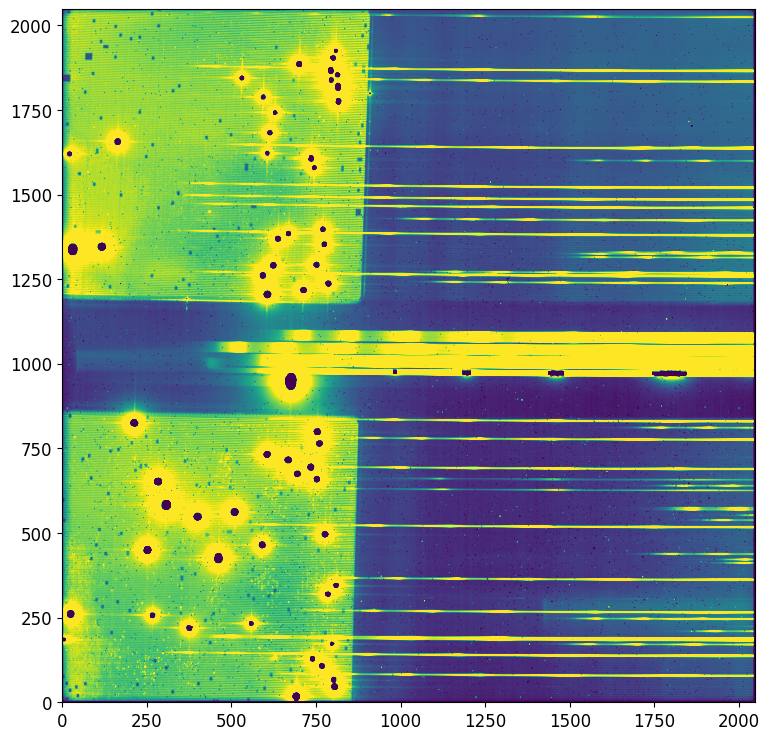

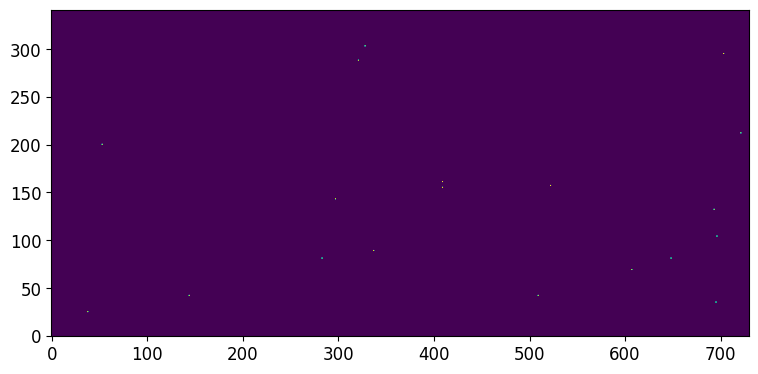

2022-10-06 00:38:19,601 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-06 00:38:19,612 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-06 00:38:19,866 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2022-10-06 00:38:19,867 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.45, 'slit_y_high': 0.45}


2022-10-06 00:38:20,012 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1


2022-10-06 00:38:20,070 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2022-10-06 00:38:20,071 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2022-10-06 00:38:20,071 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg


2022-10-06 00:38:20,073 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:38:20,259 - stpipe.AssignWcsStep - INFO - Removing slit 1 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:20,272 - stpipe.AssignWcsStep - INFO - Removing slit 2 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:20,323 - stpipe.AssignWcsStep - INFO - Removing slit 6 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:38:20,481 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS1: [3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


2022-10-06 00:38:20,482 - stpipe.AssignWcsStep - INFO - Computing WCS for 16 open slitlets


2022-10-06 00:38:20,519 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2022-10-06 00:38:20,519 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2022-10-06 00:38:20,520 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg


2022-10-06 00:38:20,521 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:38:20,534 - stpipe.AssignWcsStep - INFO - SPORDER= -1, wrange=[9.7e-07, 1.89e-06]


2022-10-06 00:38:20,682 - stpipe.AssignWcsStep - INFO - There are 3 open slits in quadrant 1


2022-10-06 00:38:20,706 - stpipe.AssignWcsStep - INFO - There are 2 open slits in quadrant 2


2022-10-06 00:38:20,721 - stpipe.AssignWcsStep - INFO - There are 9 open slits in quadrant 3


2022-10-06 00:38:20,791 - stpipe.AssignWcsStep - INFO - There are 2 open slits in quadrant 4


2022-10-06 00:38:20,808 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5


2022-10-06 00:38:20,965 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0032.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0023.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafile': 'fopens_metafile_msa.fits'}


2022-10-06 00:38:21,645 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-10-06 00:38:21,660 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:38:21,660 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done



Working with slit/slice:  3
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[1677 2048]
 [1630 1640]]
Max value in slity array (ignoring NANs):  0.49983590702157094
percentage of F/O trace that was flagged: 99.8


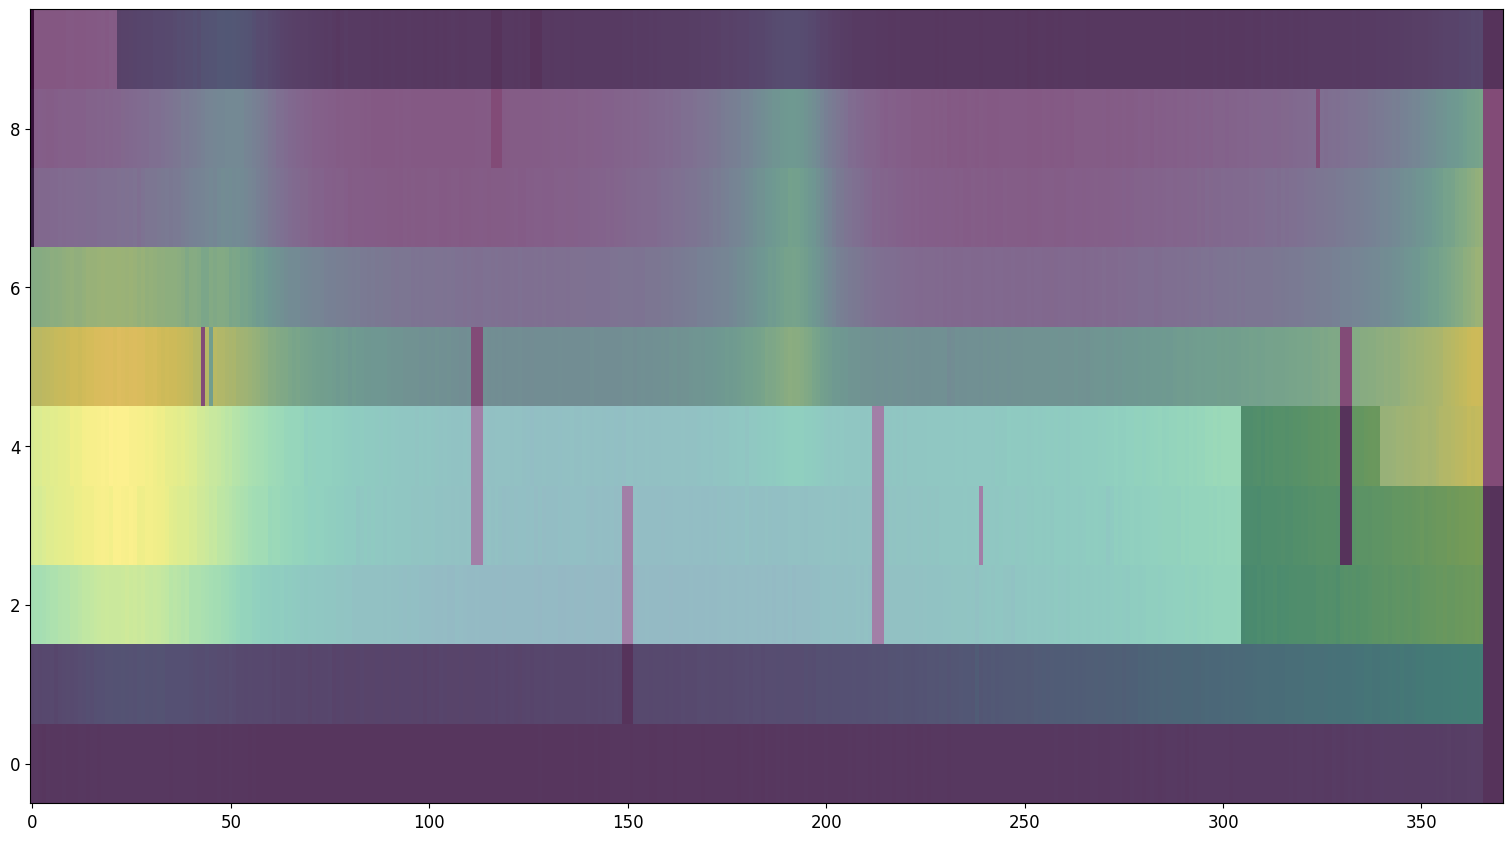


Working with slit/slice:  4
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[1628 2048]
 [1320 1330]]
Max value in slity array (ignoring NANs):  0.4999416262418918
percentage of F/O trace that was flagged: 99.8


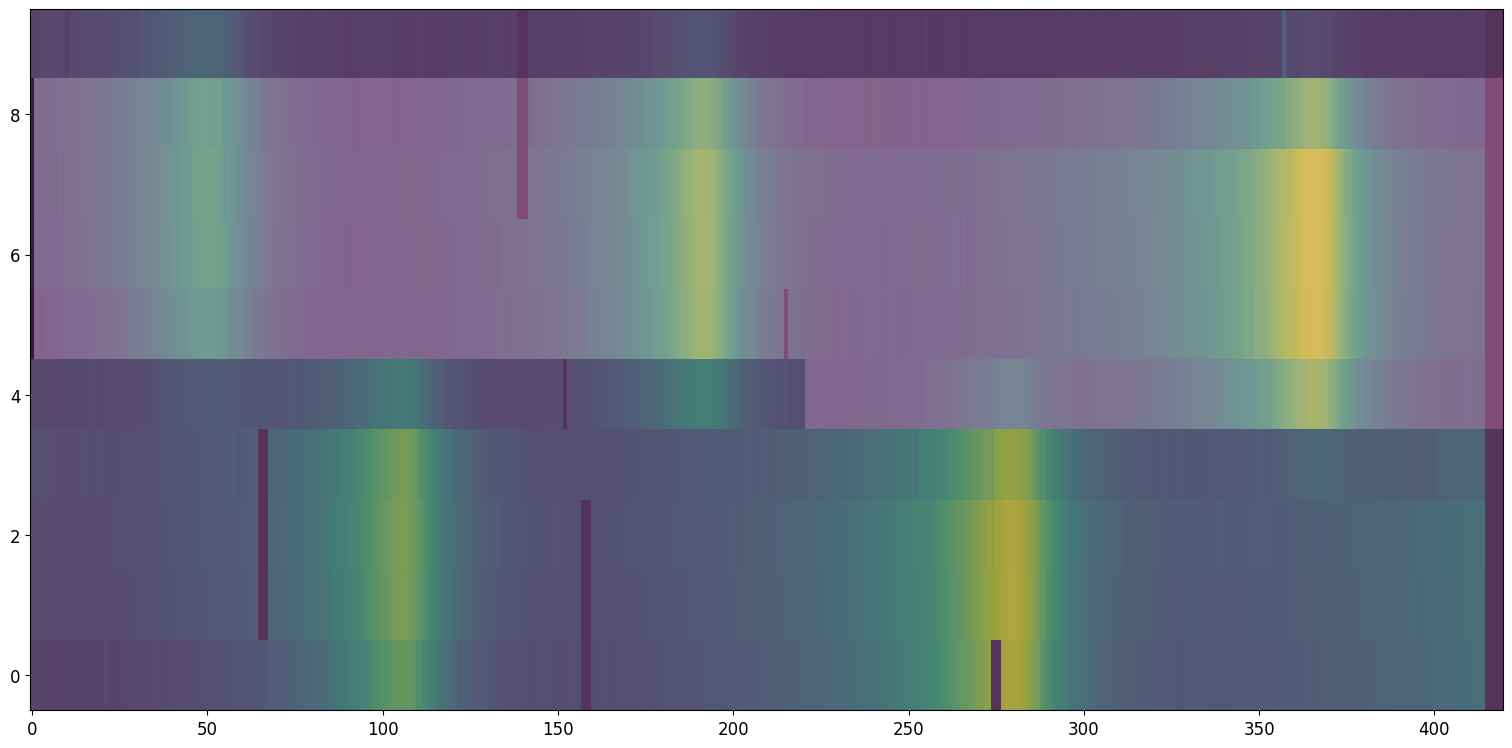


Working with slit/slice:  5
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[1536 2048]
 [1592 1602]]
Max value in slity array (ignoring NANs):  0.499395872247531
percentage of F/O trace that was flagged: 100.0


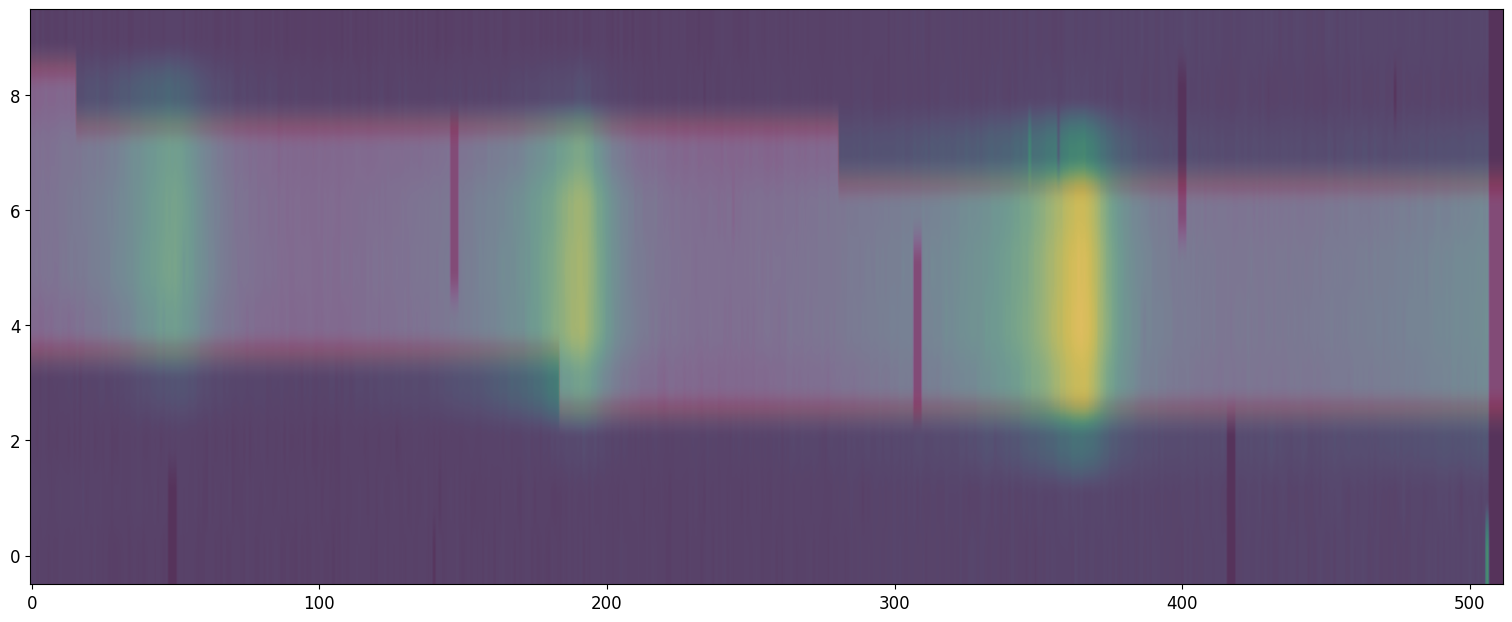


Working with slit/slice:  7
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[1531 2048]
 [ 240  250]]


Max value in slity array (ignoring NANs):  0.49982577845792203
percentage of F/O trace that was flagged: 100.0


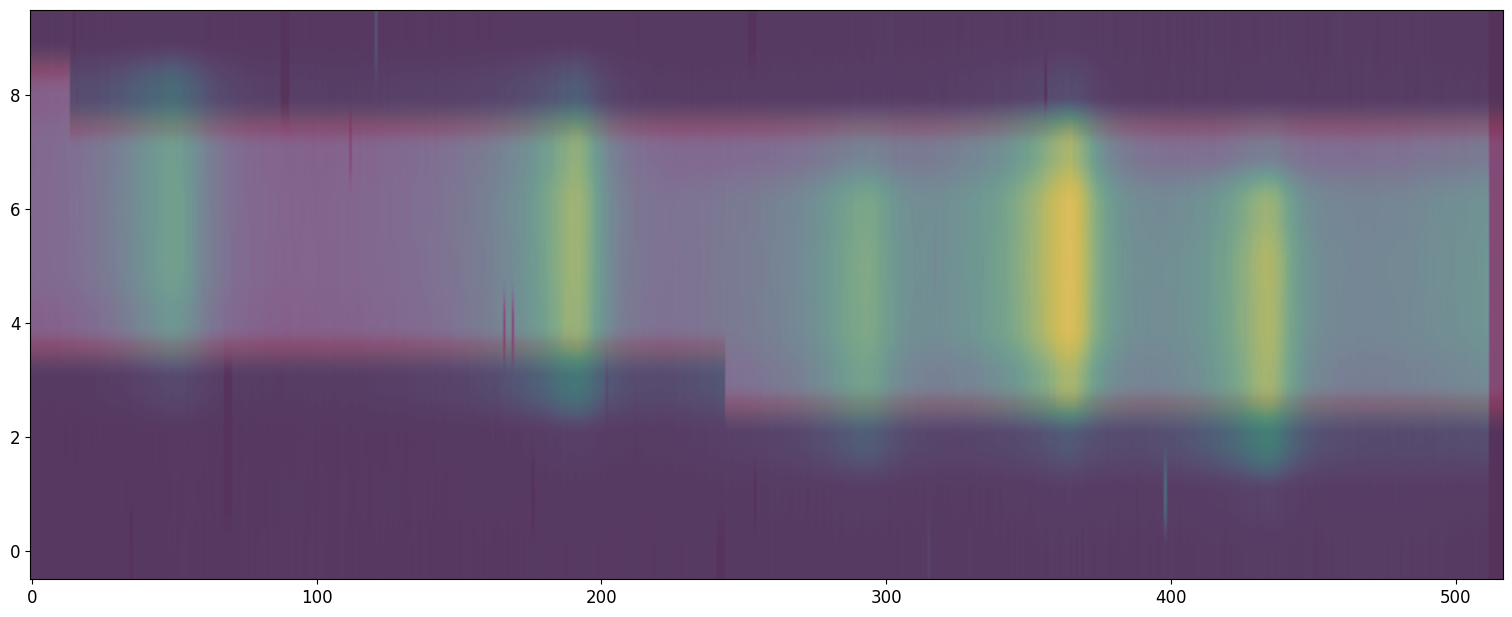


Working with slit/slice:  8
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[1510 2048]
 [ 164  174]]
Max value in slity array (ignoring NANs):  0.4999363264129128
percentage of F/O trace that was flagged: 99.8


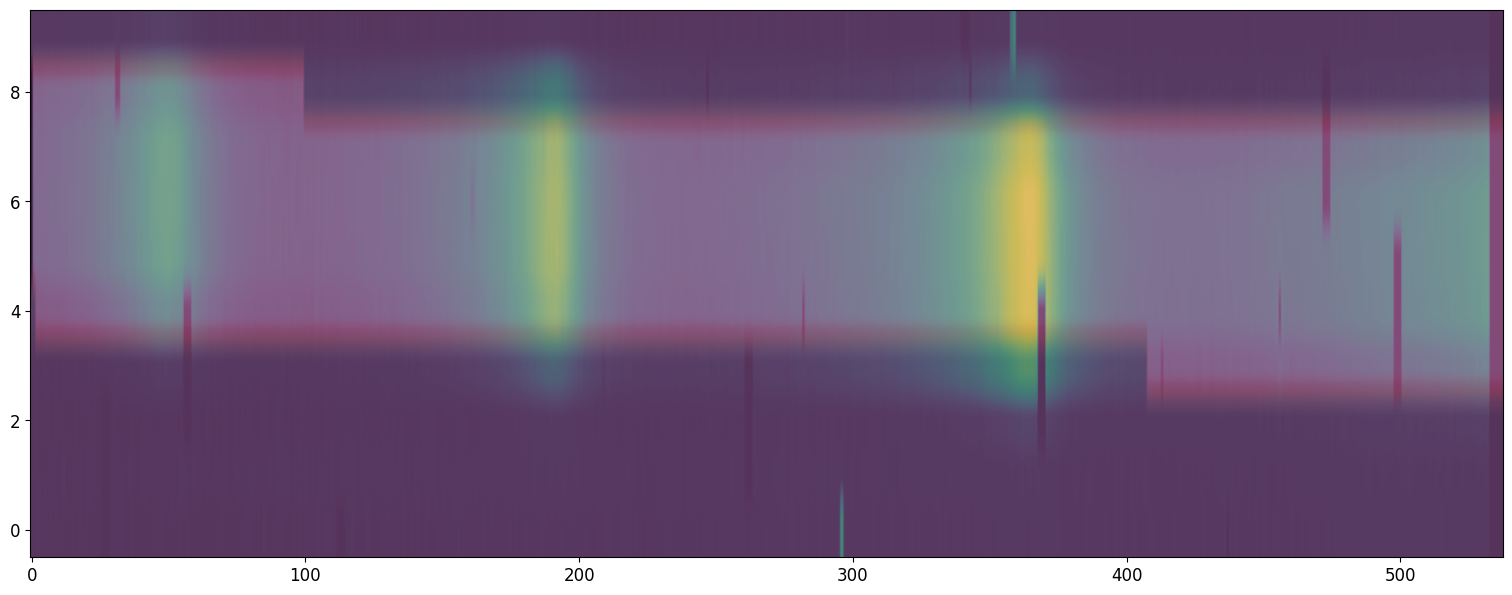


Working with slit/slice:  9
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[1114 2048]
 [1260 1272]]
Max value in slity array (ignoring NANs):  0.49973662248892214
percentage of F/O trace that was flagged: 99.9


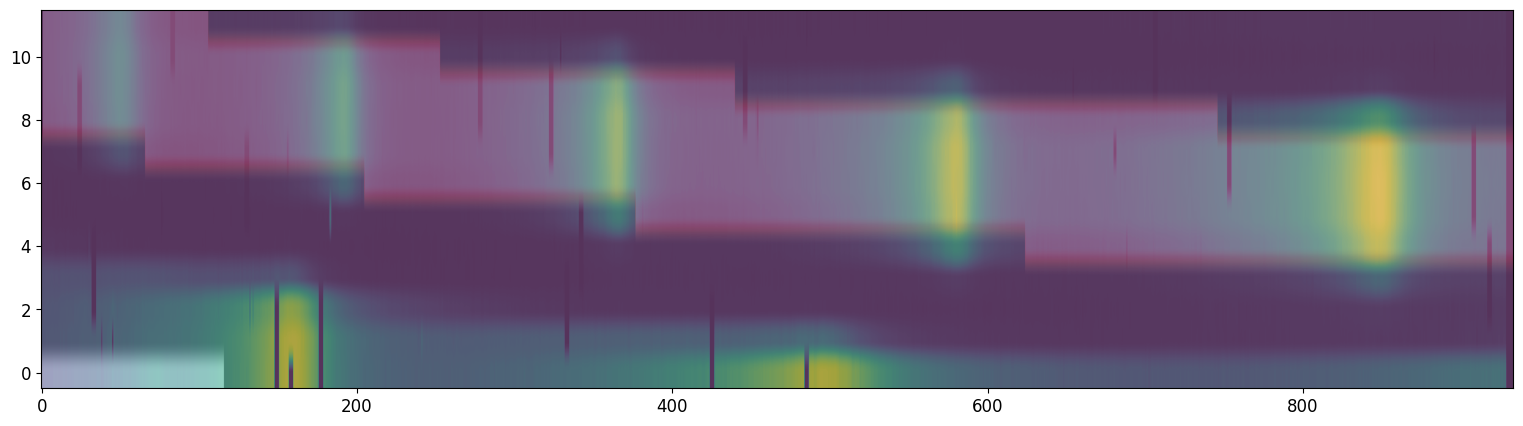


Working with slit/slice:  10
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[1113 2048]
 [1230 1242]]
Max value in slity array (ignoring NANs):  0.499843929708657
percentage of F/O trace that was flagged: 99.9


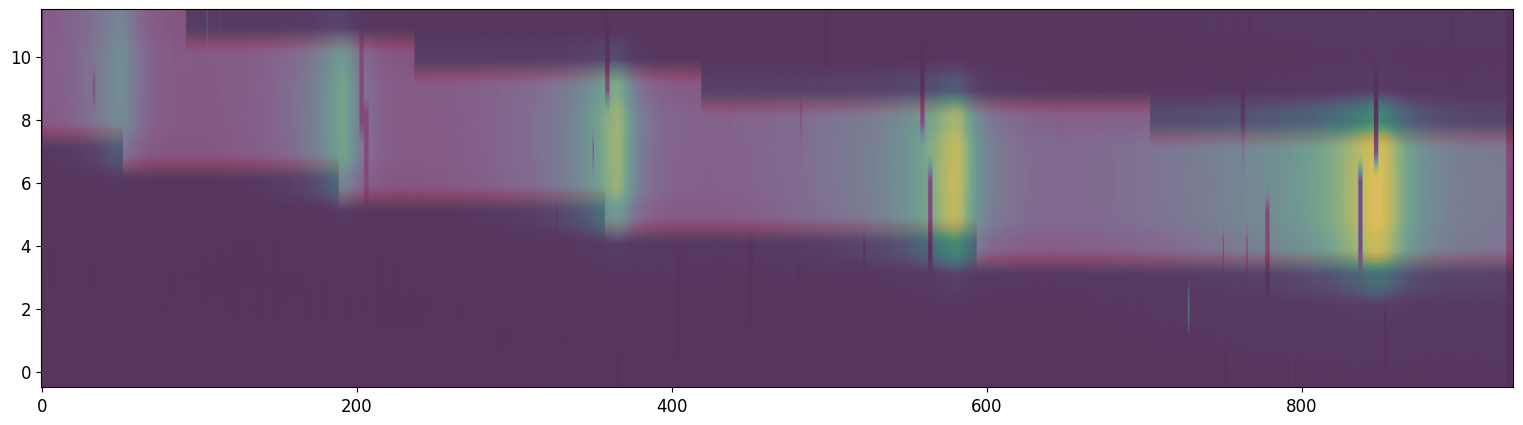


Working with slit/slice:  11
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 881 2048]
 [1826 1840]]
Max value in slity array (ignoring NANs):  0.49948331088759856
percentage of F/O trace that was flagged: 100.0


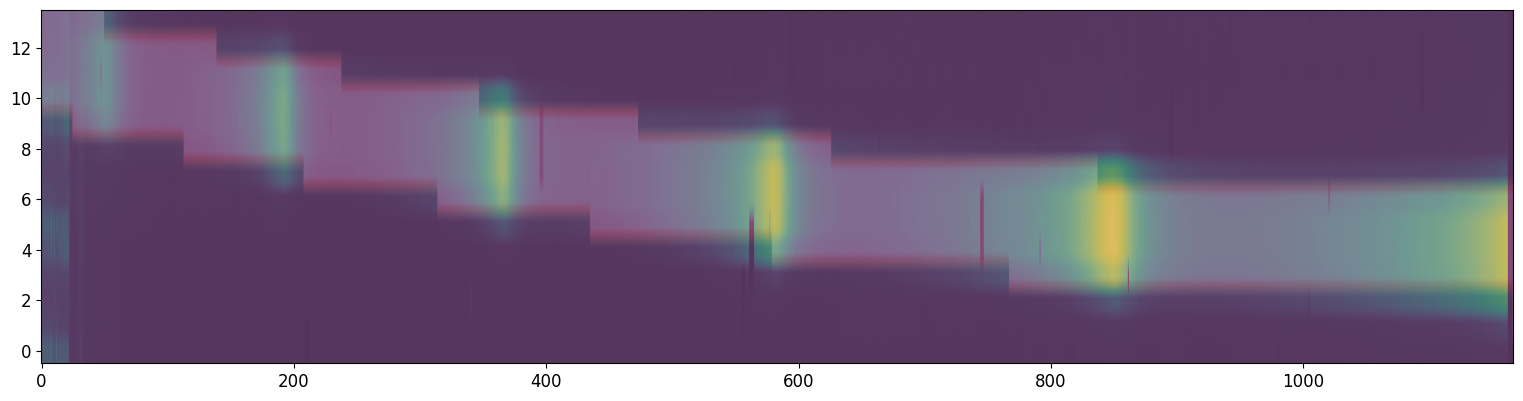


Working with slit/slice:  12
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 822 2048]
 [1250 1264]]
Max value in slity array (ignoring NANs):  0.4997723843713606
percentage of F/O trace that was flagged: 100.0


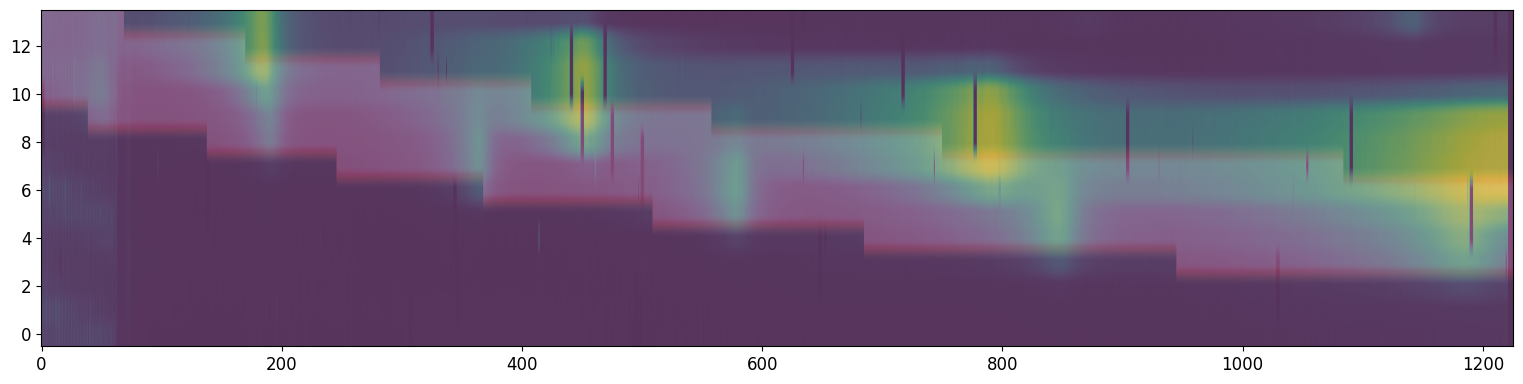


Working with slit/slice:  13
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 622 2048]
 [1688 1708]]
Max value in slity array (ignoring NANs):  0.4999716020776064
percentage of F/O trace that was flagged: 99.9


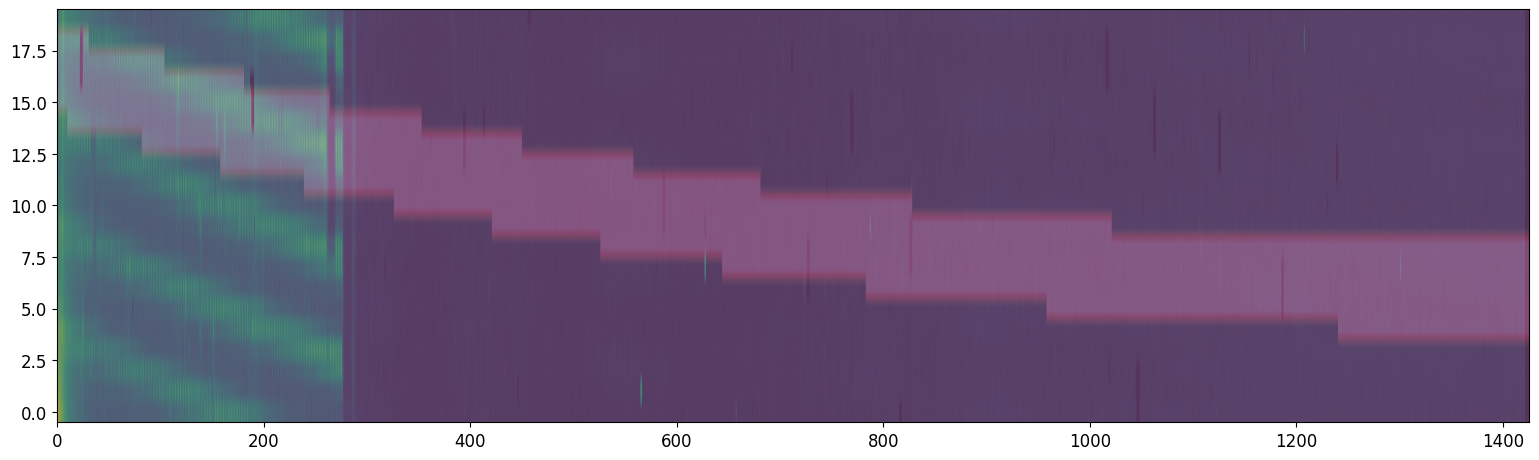


Working with slit/slice:  14
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 514 1982]
 [1628 1648]]
Max value in slity array (ignoring NANs):  0.4997611753551952
percentage of F/O trace that was flagged: 100.0


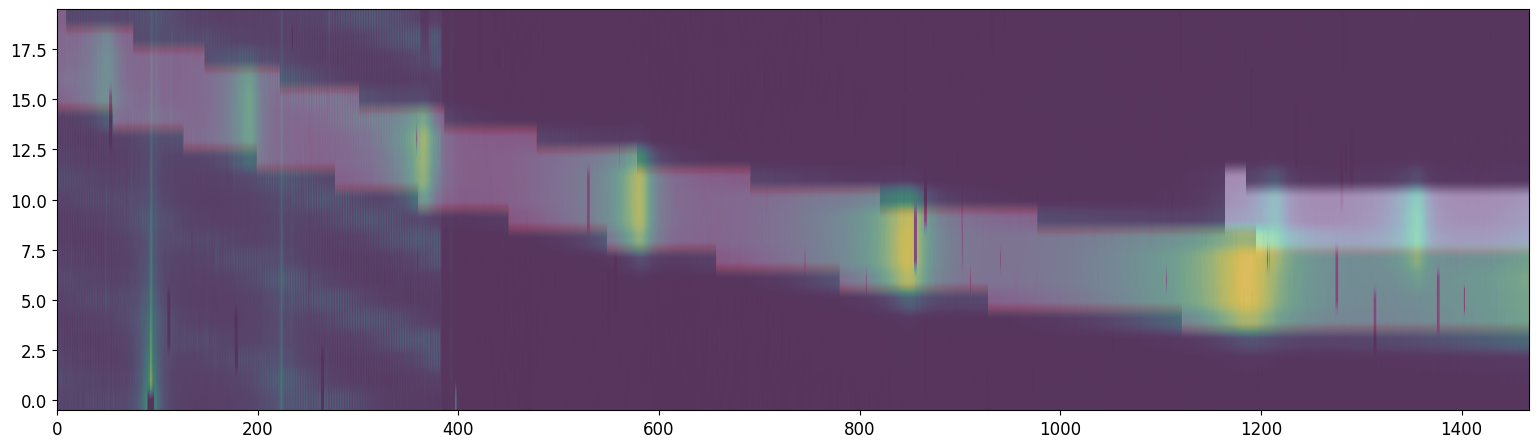


Working with slit/slice:  15
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 386 1852]
 [1372 1394]]
Max value in slity array (ignoring NANs):  0.49974517536774626
percentage of F/O trace that was flagged: 100.0


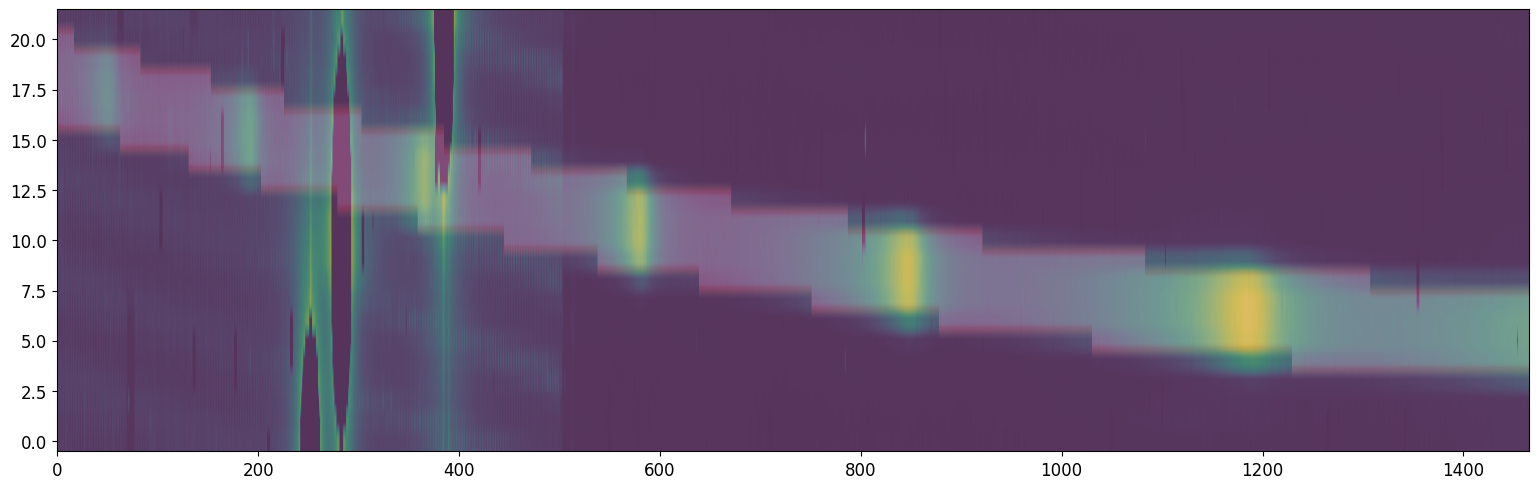


Working with slit/slice:  16
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 404 1873]
 [1856 1880]]
Max value in slity array (ignoring NANs):  0.4997112322262246
percentage of F/O trace that was flagged: 100.0


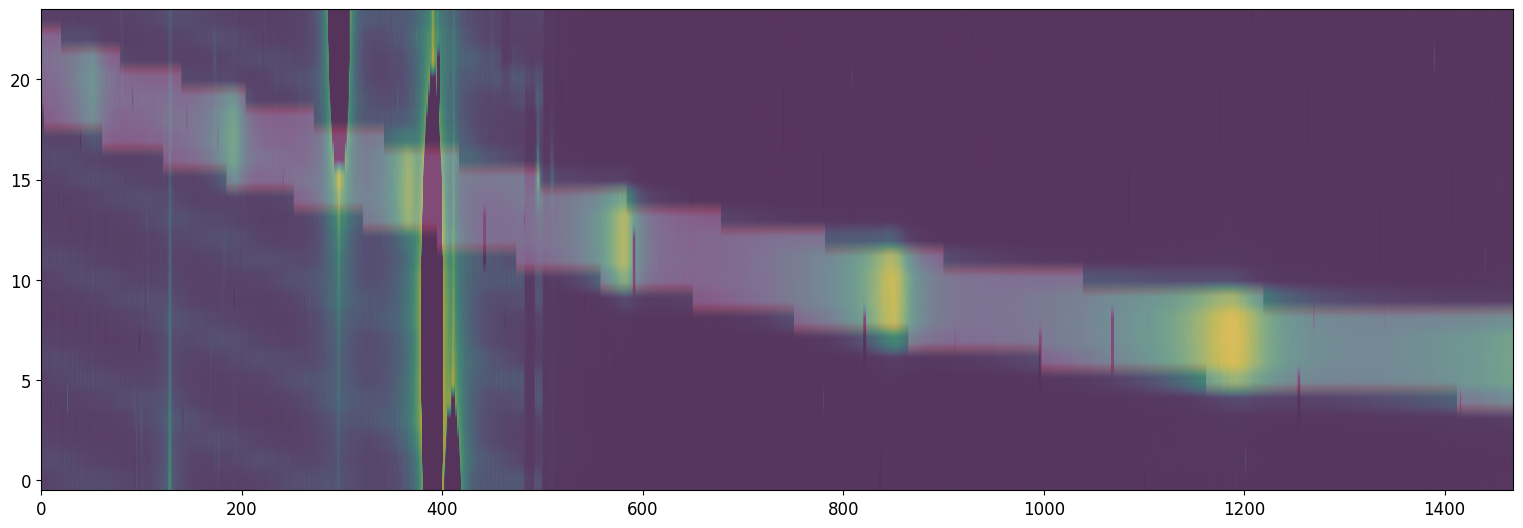


Working with slit/slice:  17
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 385 1852]
 [1512 1534]]
Max value in slity array (ignoring NANs):  0.4998204880532977
percentage of F/O trace that was flagged: 100.0


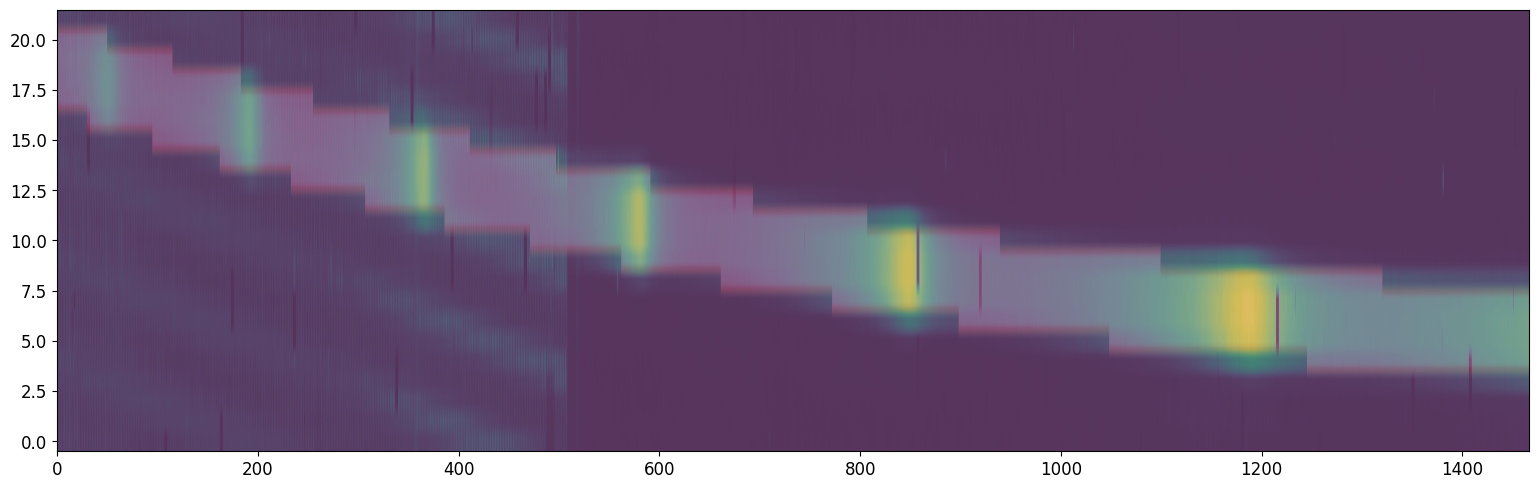


Working with slit/slice:  18
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 312 1773]
 [ 202  220]]


Max value in slity array (ignoring NANs):  0.4999855029608435
percentage of F/O trace that was flagged: 99.9


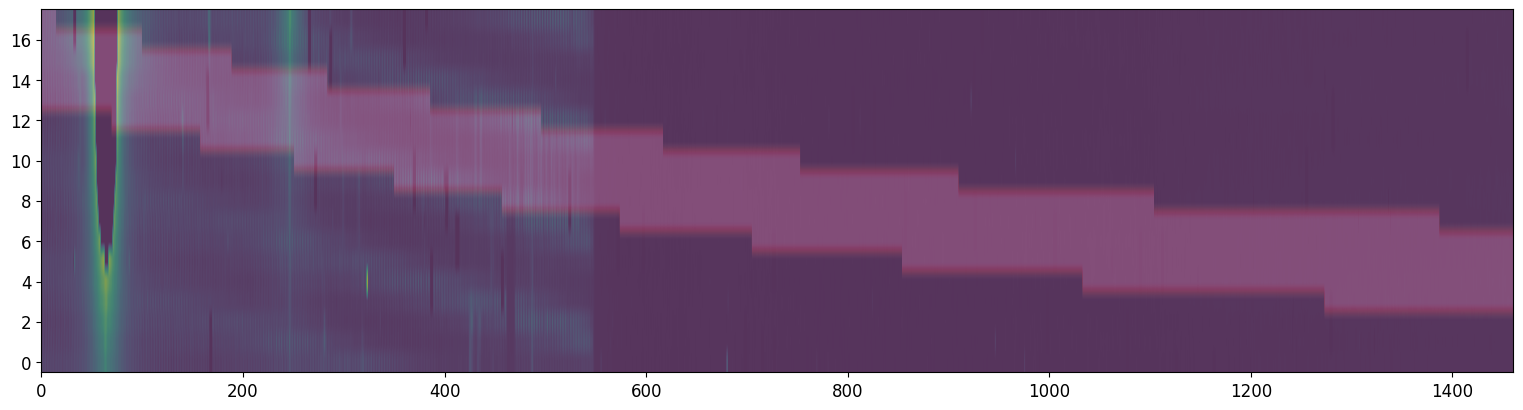


Working with slit/slice:  19
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 282 1744]
 [ 620  640]]
Max value in slity array (ignoring NANs):  0.49987583080741427
percentage of F/O trace that was flagged: 100.0


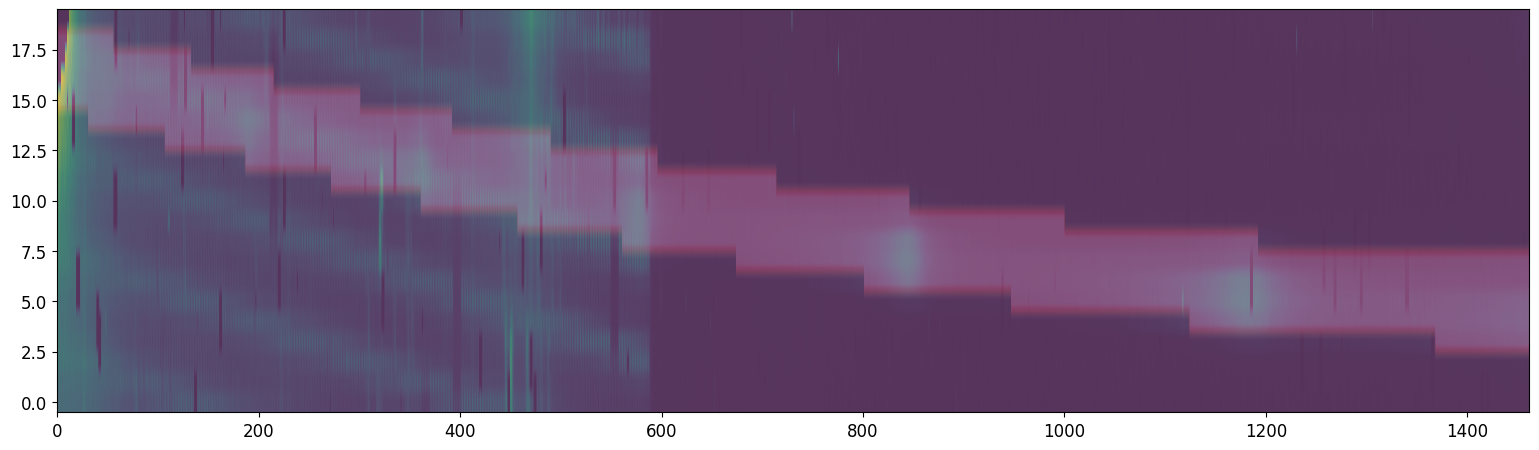


 *** Final result for msa_flagging test will be reported as PASSED *** 

('* MSA flagging validation test took ', '16.913641452789307 seconds to finish.')
Did msa_flagging validation test pass?  True 


Testing files for detector:  nrs2


2022-10-06 00:38:36,233 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


Working with uncal_file:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki/mos_g140m_line1_NRS2_uncal.fits


2022-10-06 00:38:36,249 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-06 00:38:36,250 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-06 00:38:36,251 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-06 00:38:36,252 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-06 00:38:36,254 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-06 00:38:36,254 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-06 00:38:36,255 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-06 00:38:36,256 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-06 00:38:36,257 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-06 00:38:36,259 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-06 00:38:36,260 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-06 00:38:36,261 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-06 00:38:36,262 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-06 00:38:36,263 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-06 00:38:36,264 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-06 00:38:36,265 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-06 00:38:36,267 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-06 00:38:36,471 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki/mos_g140m_line1_NRS2_uncal.fits',).


2022-10-06 00:38:36,481 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-10-06 00:38:36,651 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'mos_g140m_line1_NRS2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-06 00:38:36,662 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0143.fits'.


2022-10-06 00:38:36,663 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits'.


2022-10-06 00:38:36,665 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0020.fits'.


2022-10-06 00:38:36,666 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0025.fits'.


2022-10-06 00:38:36,667 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-06 00:38:36,667 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0016.fits'.


2022-10-06 00:38:36,669 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-10-06 00:38:36,669 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-06 00:38:36,669 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-10-06 00:38:36,670 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0022.fits'.


2022-10-06 00:38:36,671 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0104.fits'.


2022-10-06 00:38:36,673 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-06 00:38:36,673 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-06 00:38:36,674 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-06 00:38:37,019 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:38:37,020 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki'}


2022-10-06 00:38:37,142 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-10-06 00:38:37,142 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-06 00:38:37,145 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-06 00:38:37,279 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:38:37,280 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki'}


2022-10-06 00:38:37,301 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0025.fits


2022-10-06 00:38:37,732 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-06 00:38:38,026 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:38:38,028 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki', 'n_pix_grow_sat': 1}


2022-10-06 00:38:38,052 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0022.fits


2022-10-06 00:38:39,968 - stpipe.Detector1Pipeline.saturation - INFO - Detected 123449 saturated pixels


2022-10-06 00:38:39,998 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-06 00:38:40,013 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-06 00:38:40,178 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:38:40,180 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki'}


2022-10-06 00:38:40,180 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-06 00:38:40,183 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-06 00:38:40,312 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:38:40,313 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki'}


2022-10-06 00:38:40,336 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0104.fits


2022-10-06 00:38:40,851 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-10-06 00:38:40,988 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:38:40,990 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-06 00:38:41,112 - stpipe.Detector1Pipeline.refpix - INFO - NIR full frame data


2022-10-06 00:38:41,113 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are valid for this mode:


2022-10-06 00:38:41,113 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-10-06 00:38:41,114 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-10-06 00:38:41,114 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-10-06 00:38:41,114 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-10-06 00:38:41,115 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is not applicable and is ignored:


2022-10-06 00:38:41,115 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = False


2022-10-06 00:38:43,549 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-06 00:38:43,686 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:38:43,688 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki'}


2022-10-06 00:38:43,711 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0020.fits


2022-10-06 00:38:47,068 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-06 00:38:47,218 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:38:47,219 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki', 'dark_output': None}


2022-10-06 00:38:47,246 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0143.fits


2022-10-06 00:38:49,149 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=6, nframes=1, groupgap=0


2022-10-06 00:38:49,150 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=10, nframes=1, groupgap=0


2022-10-06 00:38:49,443 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-06 00:38:49,595 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:38:49,597 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-06 00:38:49,607 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-06 00:38:49,621 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2022-10-06 00:38:49,692 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0016.fits


2022-10-06 00:38:50,045 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-06 00:38:50,103 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
2022-10-06 00:38:52,320 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51081 pixels with at least one CR from five or more groups.


2022-10-06 00:38:52,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3363 pixels with at least one CR from four groups.


2022-10-06 00:38:52,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2685 pixels with at least one CR from three groups.


2022-10-06 00:39:01,780 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 11.734 sec


2022-10-06 00:39:01,784 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 12.177668


2022-10-06 00:39:01,790 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-06 00:39:01,929 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:39:01,930 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-06 00:39:01,966 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0016.fits


2022-10-06 00:39:01,967 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2022-10-06 00:39:02,090 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-06 00:39:02,091 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-10-06 00:39:27,898 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 6


2022-10-06 00:39:27,899 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-10-06 00:39:28,064 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-06 00:39:28,241 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:39:28,243 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki'}


2022-10-06 00:39:28,314 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 00:39:28,315 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 00:39:28,320 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 00:39:28,454 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:39:28,456 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki'}


2022-10-06 00:39:28,525 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 00:39:28,526 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 00:39:28,530 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 00:39:28,531 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-06 00:39:28,531 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:39:28,532 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-06 00:39:28,541 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-06 00:39:28,677 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:39:28,679 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


Using MSA shutter config:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki/V8460001000101_msa.fits


2022-10-06 00:39:28,836 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1


2022-10-06 00:39:29,056 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2022-10-06 00:39:29,057 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2022-10-06 00:39:29,057 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg


2022-10-06 00:39:29,059 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:39:29,948 - stpipe.AssignWcsStep - INFO - Removing slit 65 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:29,962 - stpipe.AssignWcsStep - INFO - Removing slit 66 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:29,976 - stpipe.AssignWcsStep - INFO - Removing slit 68 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:30,014 - stpipe.AssignWcsStep - INFO - Removing slit 58 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:30,028 - stpipe.AssignWcsStep - INFO - Removing slit 59 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:30,041 - stpipe.AssignWcsStep - INFO - Removing slit 60 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:30,055 - stpipe.AssignWcsStep - INFO - Removing slit 61 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:30,068 - stpipe.AssignWcsStep - INFO - Removing slit 62 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:30,081 - stpipe.AssignWcsStep - INFO - Removing slit 63 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:30,094 - stpipe.AssignWcsStep - INFO - Removing slit 64 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:30,106 - stpipe.AssignWcsStep - INFO - Removing slit 67 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:30,107 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS2: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]


2022-10-06 00:39:30,107 - stpipe.AssignWcsStep - INFO - Computing WCS for 57 open slitlets


2022-10-06 00:39:30,143 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2022-10-06 00:39:30,144 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2022-10-06 00:39:30,144 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg


2022-10-06 00:39:30,146 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:39:30,159 - stpipe.AssignWcsStep - INFO - SPORDER= -1, wrange=[9.7e-07, 1.89e-06]


2022-10-06 00:39:30,305 - stpipe.AssignWcsStep - INFO - There are 27 open slits in quadrant 1


2022-10-06 00:39:30,509 - stpipe.AssignWcsStep - INFO - There are 27 open slits in quadrant 2


2022-10-06 00:39:30,910 - stpipe.AssignWcsStep - INFO - There are 1 open slits in quadrant 3


2022-10-06 00:39:30,919 - stpipe.AssignWcsStep - INFO - There are 2 open slits in quadrant 4


2022-10-06 00:39:30,935 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5


2022-10-06 00:39:31,106 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0032.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0023.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafile': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpln7a_gki/V8460001000101_msa.fits'}


2022-10-06 00:39:32,568 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-10-06 00:39:32,582 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:39:32,583 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-10-06 00:39:32,592 - stpipe.MSAFlagOpenStep - INFO - MSAFlagOpenStep instance created.


2022-10-06 00:39:32,805 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:39:32,806 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 00:39:32,823 - stpipe.MSAFlagOpenStep - INFO - Using reference file /grp/crds/cache/references/jwst/jwst_nirspec_msaoper_0001.json


2022-10-06 00:39:32,824 - stpipe.JwstStep - INFO - JwstStep instance created.


2022-10-06 00:39:32,942 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2022-10-06 00:39:32,942 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2022-10-06 00:39:32,943 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: 0.0002496099796717191 deg


2022-10-06 00:39:32,944 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:39:32,957 - stpipe.MSAFlagOpenStep - INFO - SPORDER= -1, wrange=[9.7e-07, 1.89e-06]


2022-10-06 00:39:33,113 - stpipe.MSAFlagOpenStep - INFO - There are 5 open slits in quadrant 1


2022-10-06 00:39:33,151 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 2


2022-10-06 00:39:33,174 - stpipe.MSAFlagOpenStep - INFO - There are 9 open slits in quadrant 3


2022-10-06 00:39:33,240 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 4


2022-10-06 00:39:33,262 - stpipe.MSAFlagOpenStep - INFO - There are 0 open slits in quadrant 5


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound -103.67242647612011 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound -212.68515843943806 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound -342.07188051944695 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound -321.21045292546796 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound -342.531517365775 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound -420.84938370342115 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound -450.04257156132417 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound -459.05344370773037 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "
2022-10-06 00:39:47,544 - stpipe.MSAFlagOpenStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:39:47,544 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep done


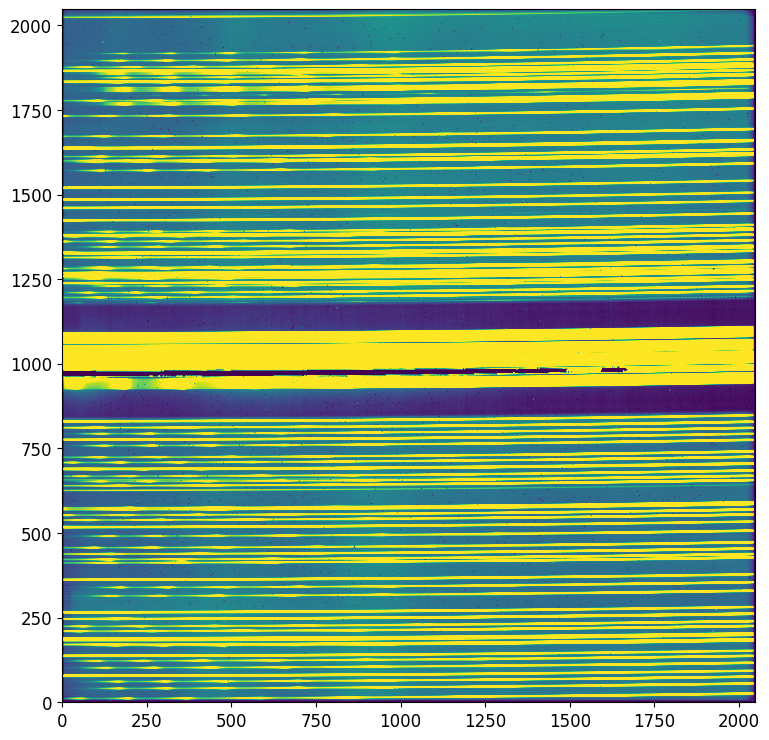

2022-10-06 00:39:48,252 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-06 00:39:48,263 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-06 00:39:48,865 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2022-10-06 00:39:48,867 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.45, 'slit_y_high': 0.45}


2022-10-06 00:39:49,003 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1


2022-10-06 00:39:49,061 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2022-10-06 00:39:49,061 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2022-10-06 00:39:49,062 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg


2022-10-06 00:39:49,063 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:39:49,400 - stpipe.AssignWcsStep - INFO - Removing slit 13 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:49,413 - stpipe.AssignWcsStep - INFO - Removing slit 14 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:49,426 - stpipe.AssignWcsStep - INFO - Removing slit 15 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:49,439 - stpipe.AssignWcsStep - INFO - Removing slit 16 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:49,453 - stpipe.AssignWcsStep - INFO - Removing slit 17 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:49,466 - stpipe.AssignWcsStep - INFO - Removing slit 18 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:49,479 - stpipe.AssignWcsStep - INFO - Removing slit 19 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:39:49,479 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS2: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


2022-10-06 00:39:49,480 - stpipe.AssignWcsStep - INFO - Computing WCS for 12 open slitlets


2022-10-06 00:39:49,516 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2022-10-06 00:39:49,517 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2022-10-06 00:39:49,517 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg


2022-10-06 00:39:49,519 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:39:49,532 - stpipe.AssignWcsStep - INFO - SPORDER= -1, wrange=[9.7e-07, 1.89e-06]


2022-10-06 00:39:49,681 - stpipe.AssignWcsStep - INFO - There are 5 open slits in quadrant 1


2022-10-06 00:39:49,720 - stpipe.AssignWcsStep - INFO - There are 3 open slits in quadrant 2


2022-10-06 00:39:49,743 - stpipe.AssignWcsStep - INFO - There are 4 open slits in quadrant 3


2022-10-06 00:39:49,773 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 4


2022-10-06 00:39:49,774 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5


2022-10-06 00:39:49,924 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0032.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0023.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafile': 'fopens_metafile_msa.fits'}


2022-10-06 00:39:50,316 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-10-06 00:39:50,330 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:39:50,330 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done



Working with slit/slice:  1
Slit min and max in y direction:  -0.5 0.5


bounding box rounded to next integer:  [[ 131 1613]
 [1906 1930]]
Max value in slity array (ignoring NANs):  0.499879629054766
percentage of F/O trace that was flagged: 100.0


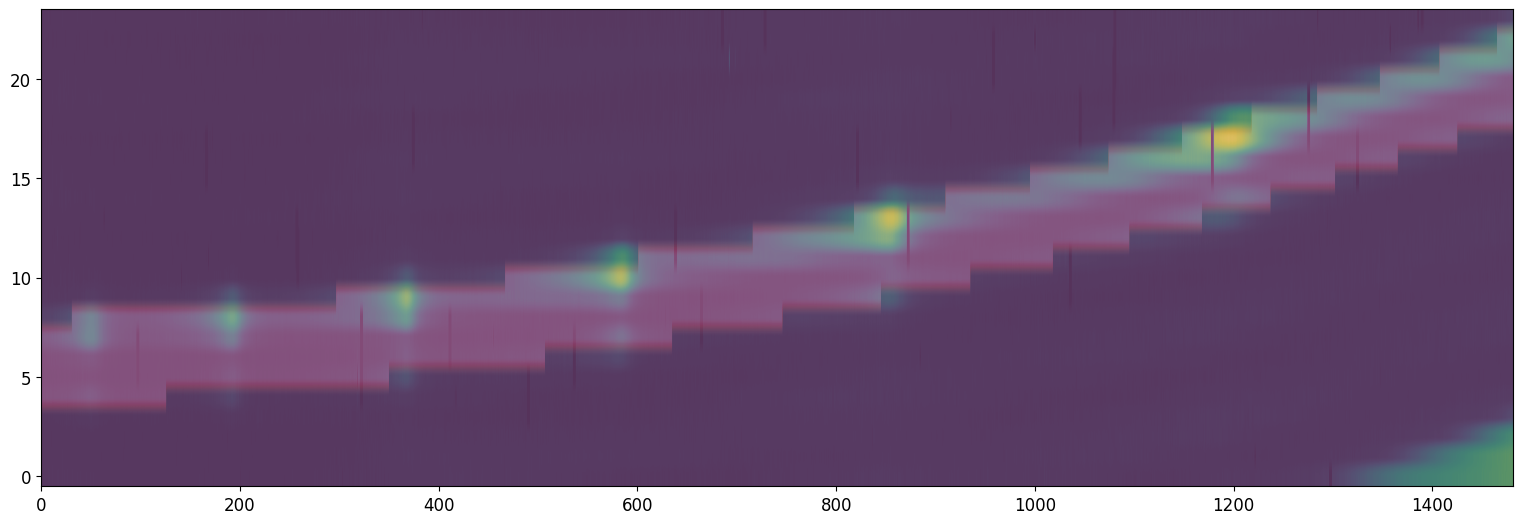


Working with slit/slice:  2
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[   0 1330]
 [1824 1842]]
Max value in slity array (ignoring NANs):  0.49995226747347604
percentage of F/O trace that was flagged: 100.0


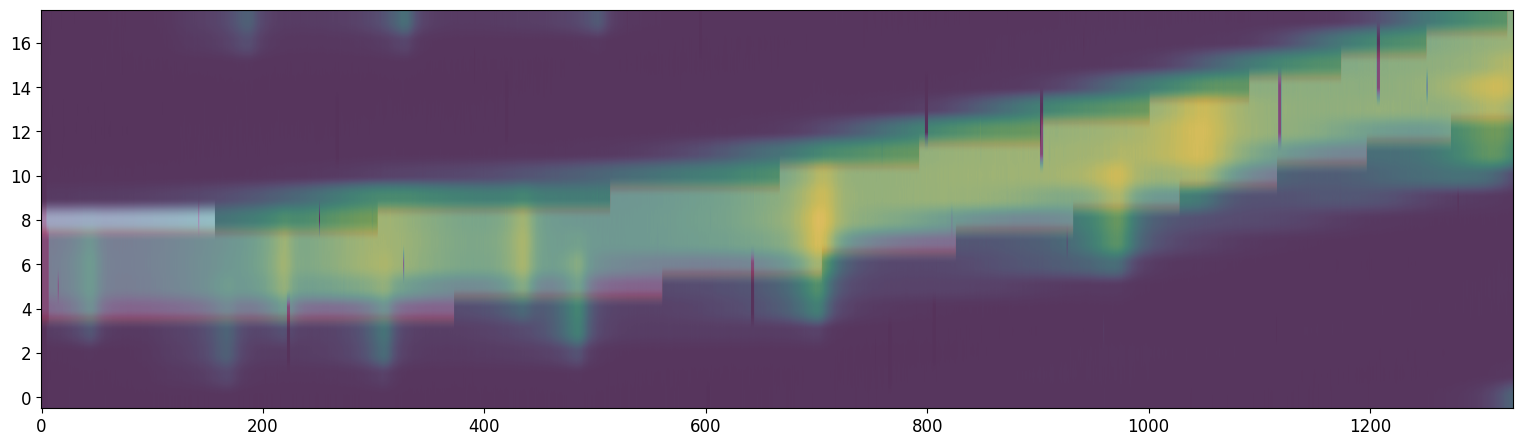


Working with slit/slice:  3
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[   0  957]
 [1632 1644]]
Max value in slity array (ignoring NANs):  0.4997648773778204
percentage of F/O trace that was flagged: 100.0


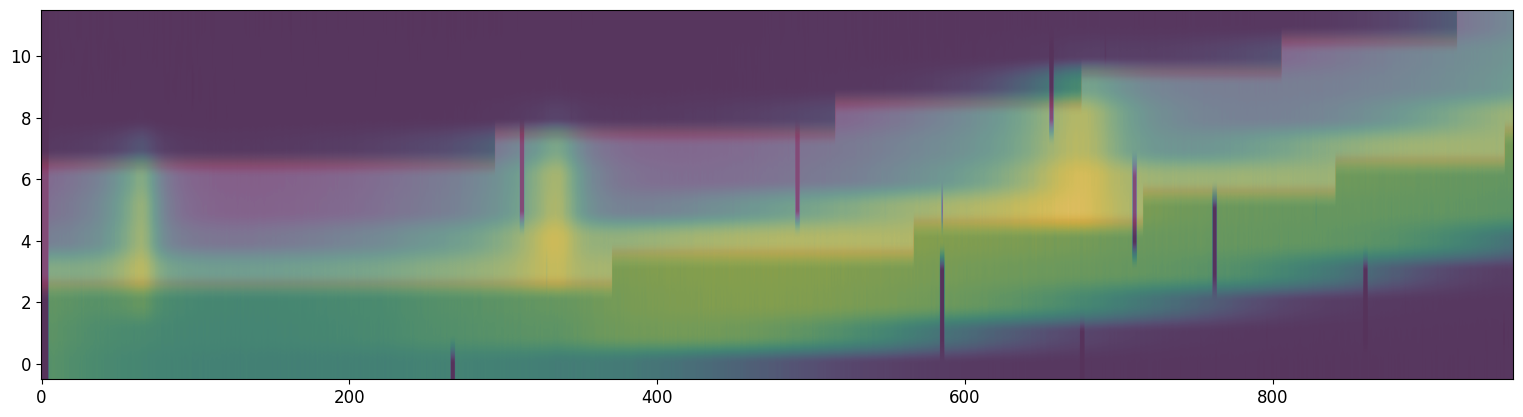


Working with slit/slice:  4
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[   0  906]
 [1320 1334]]
Max value in slity array (ignoring NANs):  0.49972723641802796
percentage of F/O trace that was flagged: 100.0


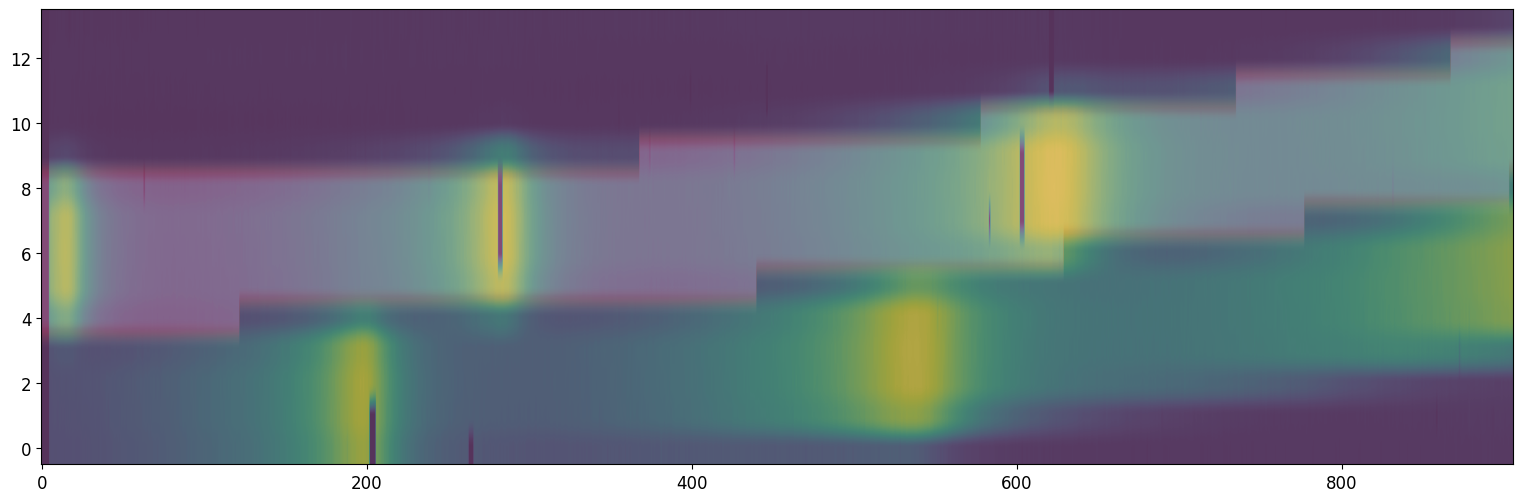


Working with slit/slice:  5
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[   0  814]
 [1592 1604]]
Max value in slity array (ignoring NANs):  0.4997225330923289
percentage of F/O trace that was flagged: 100.0


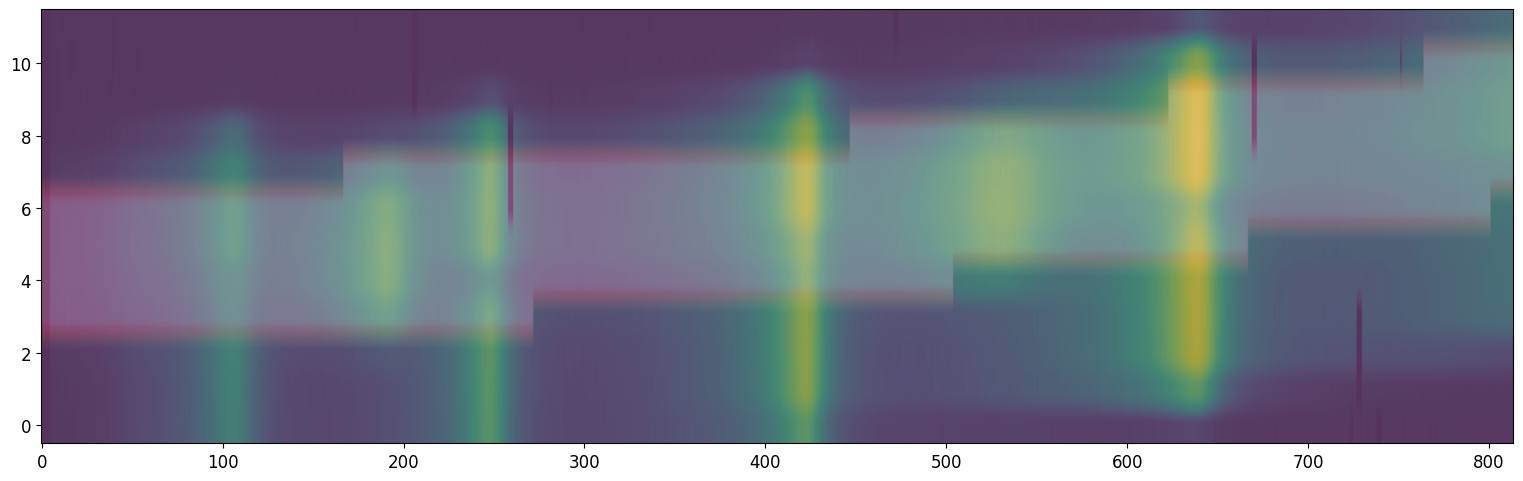


Working with slit/slice:  6
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[  50 1525]
 [ 680  698]]
Max value in slity array (ignoring NANs):  0.49989116447537363
percentage of F/O trace that was flagged: 99.9


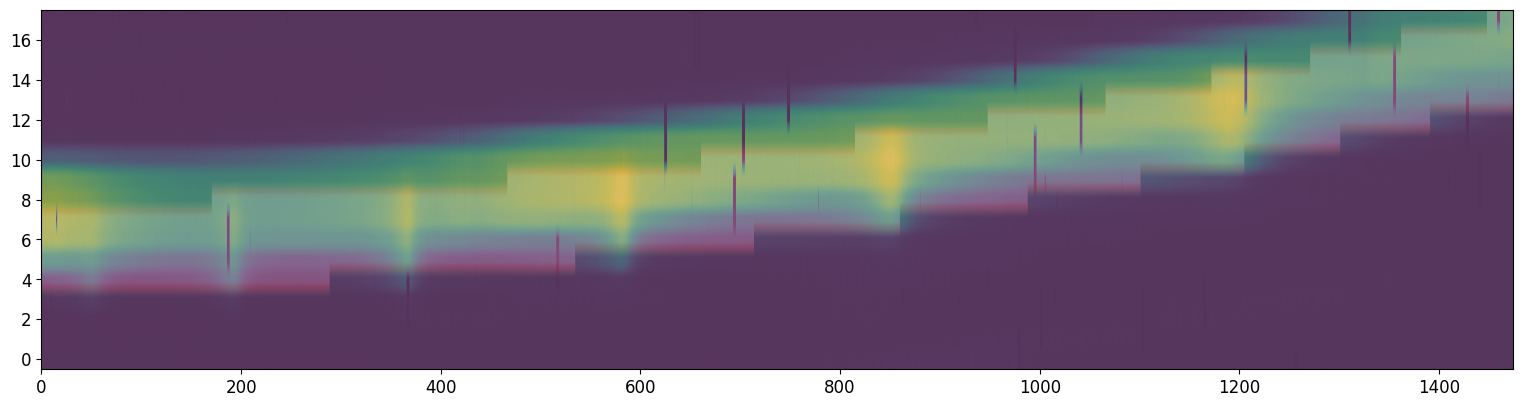


Working with slit/slice:  7
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[  0 804]
 [240 250]]
Max value in slity array (ignoring NANs):  0.49975066484744846
percentage of F/O trace that was flagged: 100.0


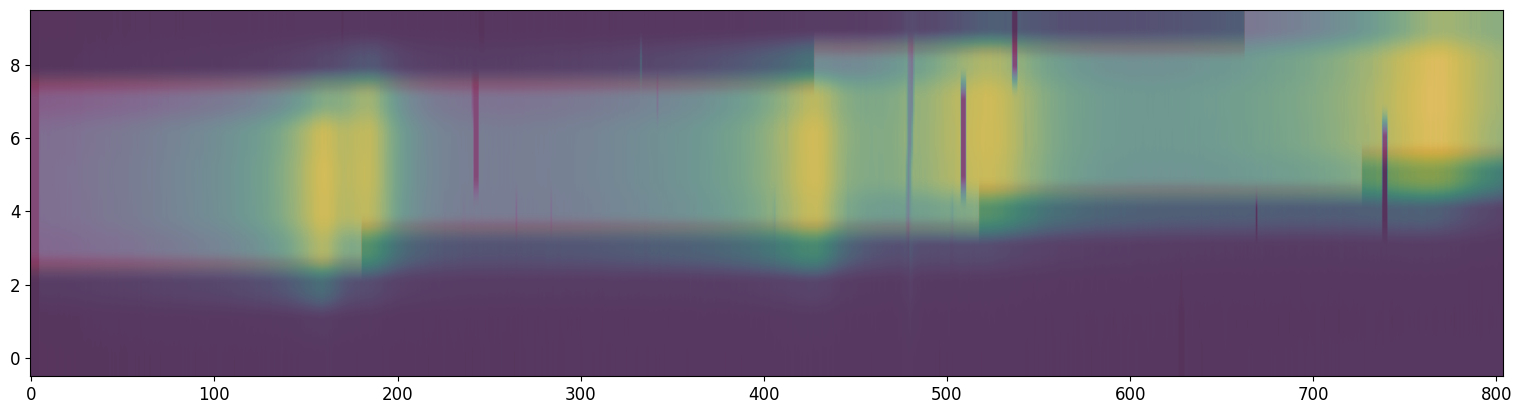


Working with slit/slice:  8
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[  0 783]
 [164 174]]
Max value in slity array (ignoring NANs):  0.49955175410051833
percentage of F/O trace that was flagged: 100.0


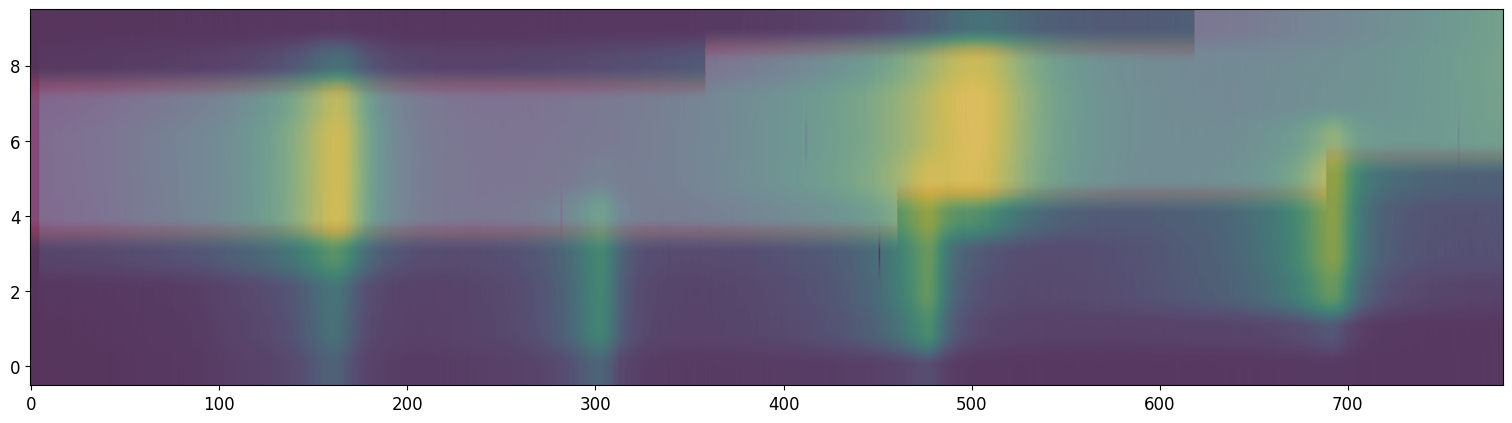


Working with slit/slice:  9
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[   0  388]
 [1260 1270]]
Max value in slity array (ignoring NANs):  0.4996146477571852
percentage of F/O trace that was flagged: 100.0


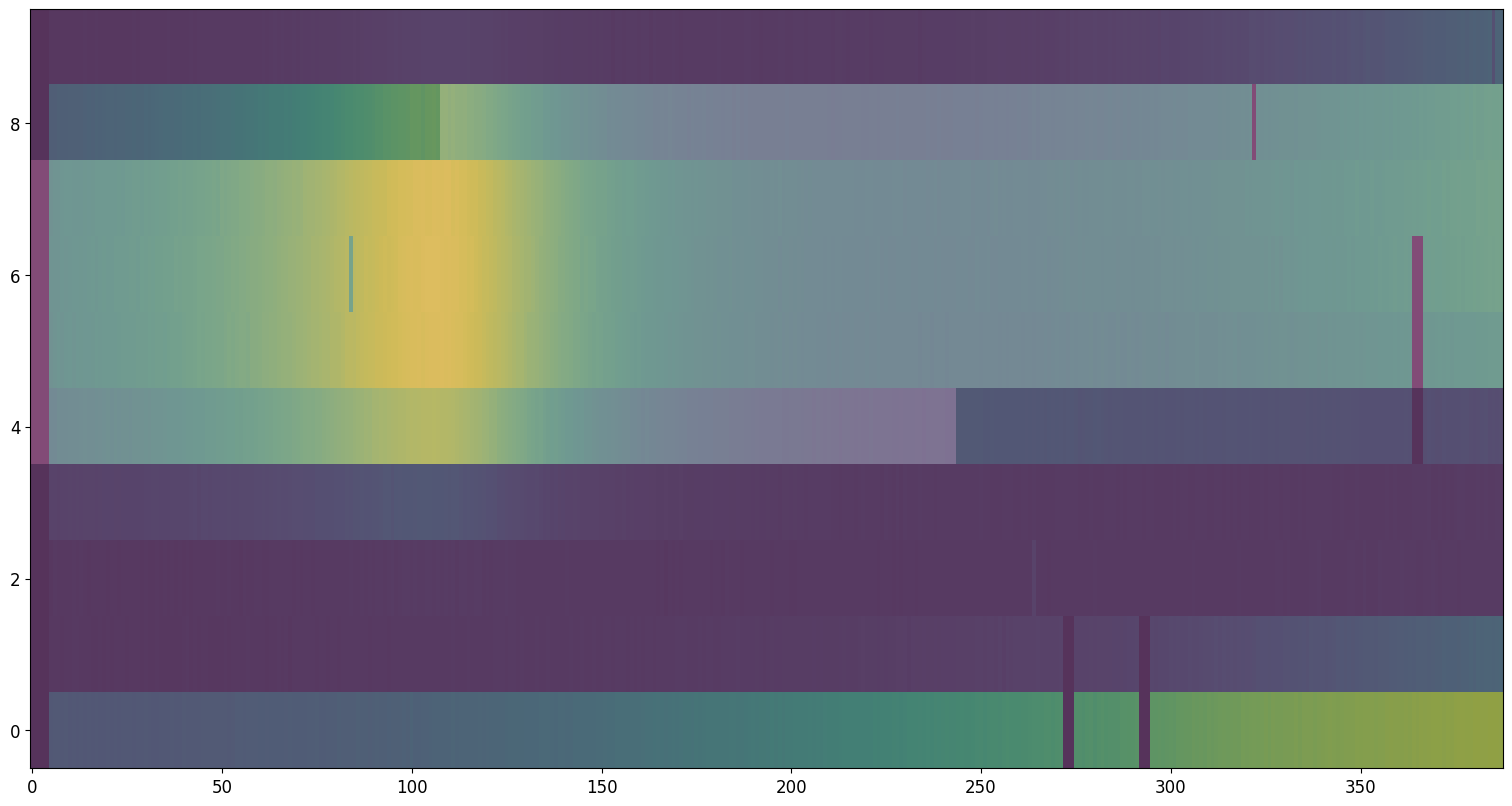


Working with slit/slice:  10
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[   0  387]
 [1230 1240]]
Max value in slity array (ignoring NANs):  0.4993629738181582
percentage of F/O trace that was flagged: 100.0


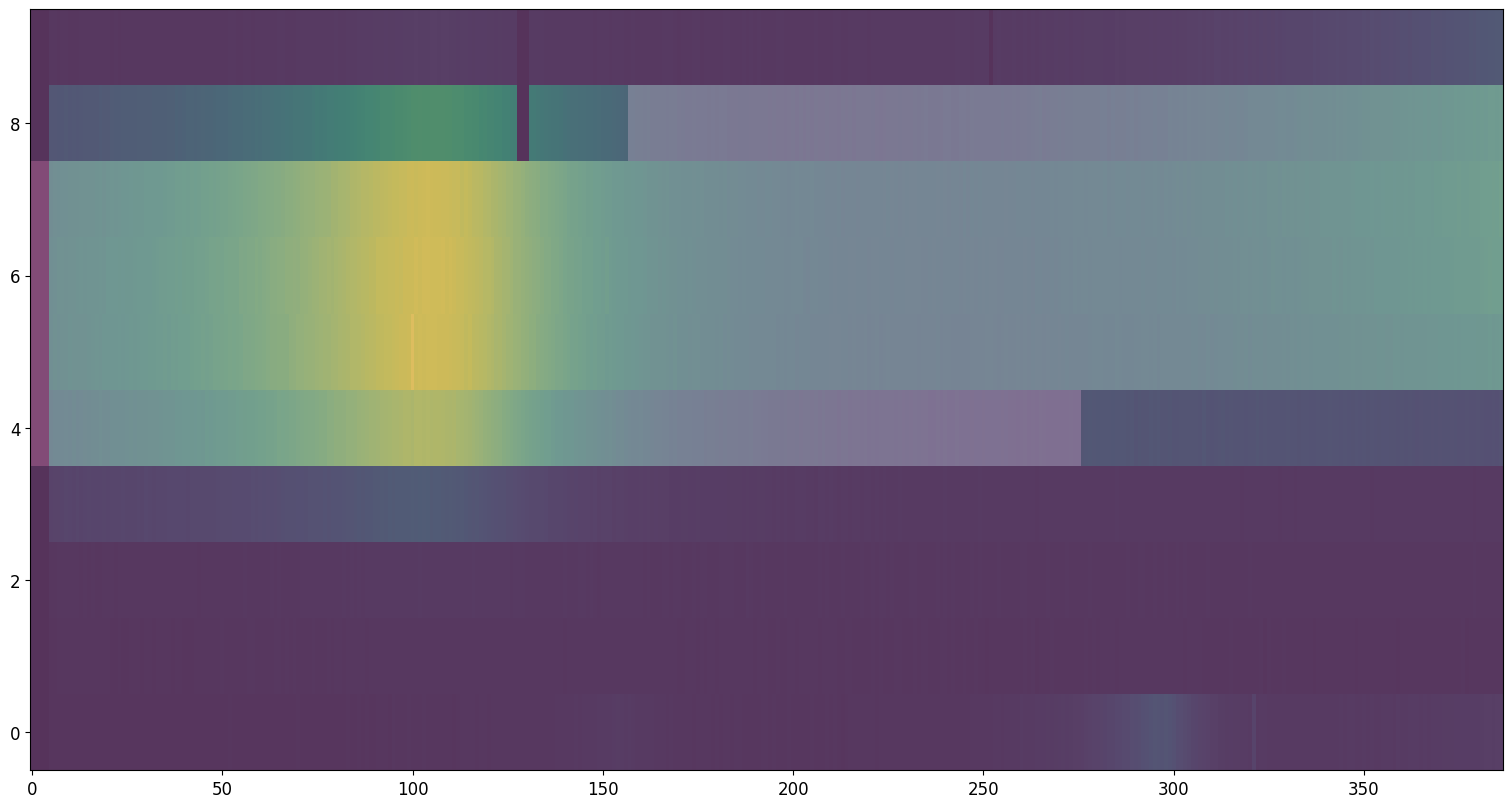


Working with slit/slice:  11
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[   0  157]
 [1826 1834]]
Max value in slity array (ignoring NANs):  0.35020493940891617
percentage of F/O trace that was flagged: 100.0


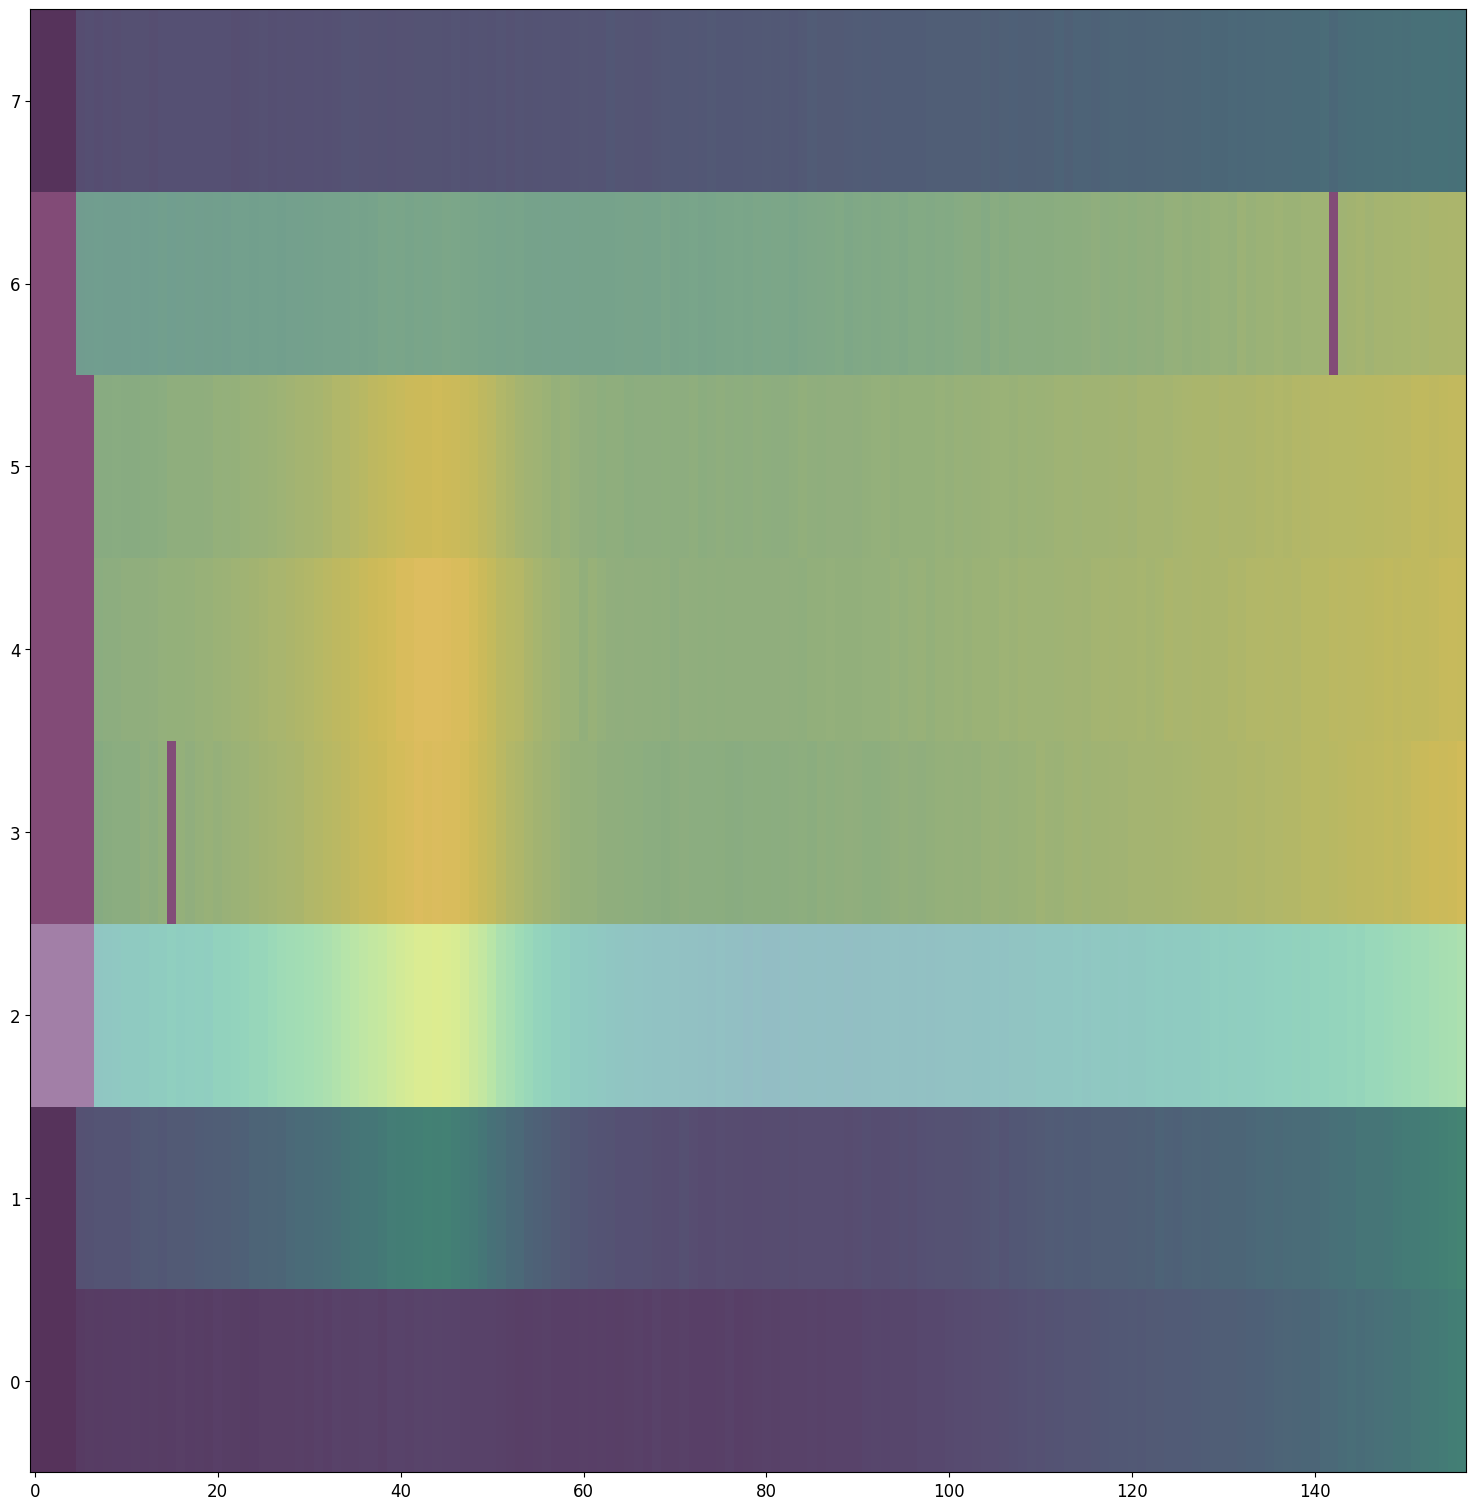


Working with slit/slice:  12
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[   0   94]
 [1250 1258]]
Max value in slity array (ignoring NANs):  0.4435073830894076
percentage of F/O trace that was flagged: 100.0


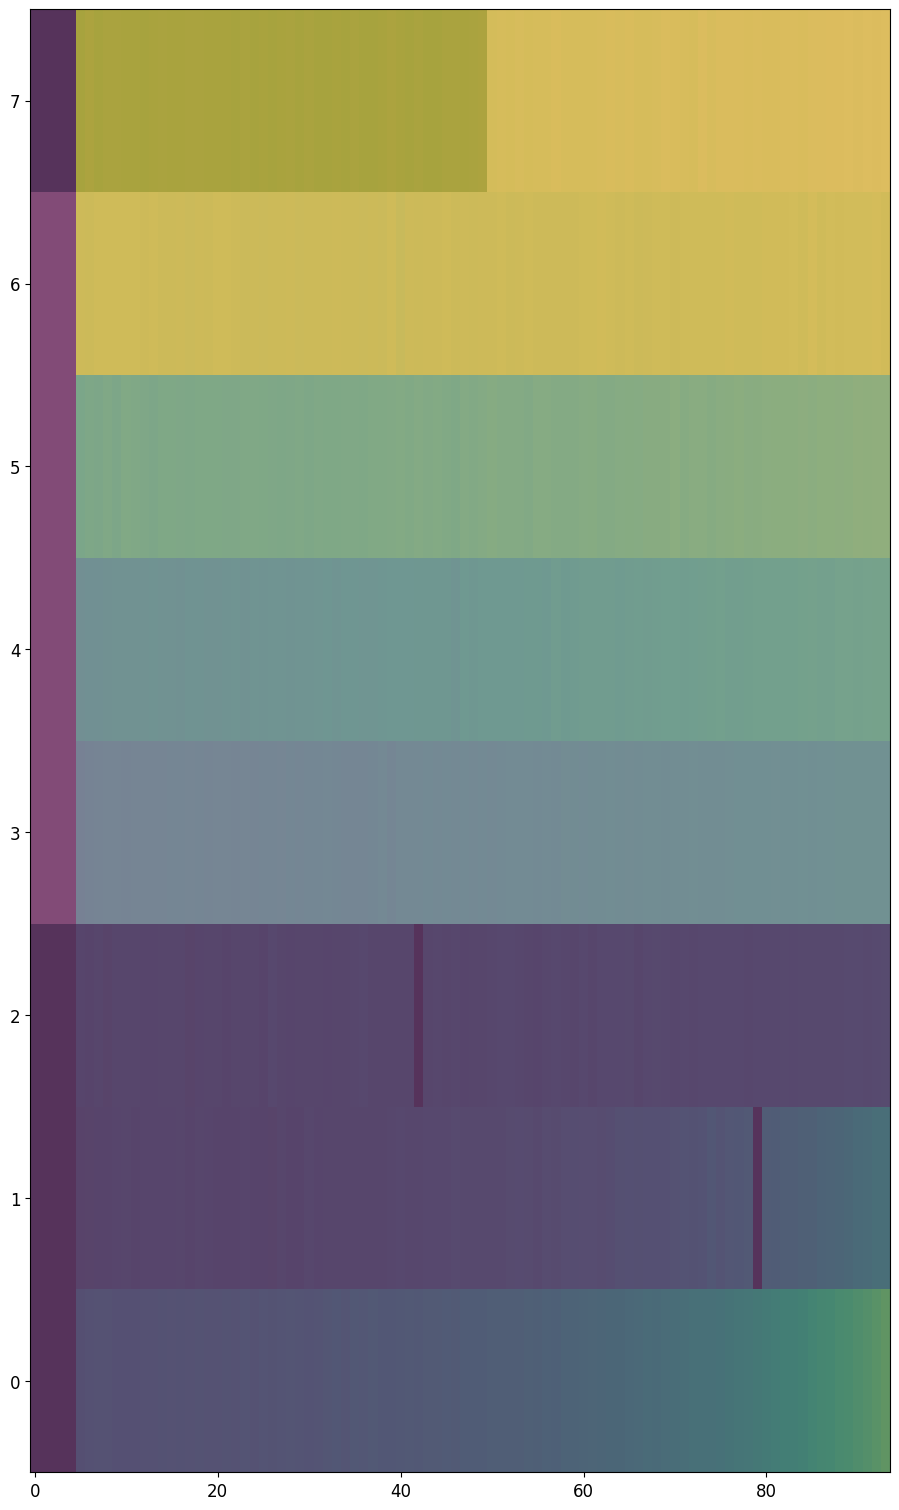


 *** Final result for msa_flagging test will be reported as PASSED *** 

('* MSA flagging validation test took ', '12.504818677902222 seconds to finish.')
Did msa_flagging validation test pass?  True 




In [7]:
# Set common NPTT switches for this test

# accepted threshold difference with respect to benchmark files
msa_flagging_threshold = 99.5

# other NPTT variables
stellarity = None
operability_ref = None
source_type = None
save_figs = False
show_figs = True
debug = False
verbose = False

# Get the data
results_dict = {}
detectors = ['nrs1', 'nrs2']
for mode_config, data_set_dict in testing_data.items():
    for det in detectors:
        print('Testing files for detector: ', det)
        data = get_artifactory_file(data_set_dict, det)
        uncal_file, msa_shutter_config = data
        print('Working with uncal_file: ', uncal_file)
        uncal_basename = os.path.basename(uncal_file)
                
        # Run the stage 1 pipeline 
        rate_object = Detector1Pipeline.call(uncal_file)
        # Make sure the MSA shutter configuration file is set up correctly
        if msa_shutter_config is not None:
            rate_object.meta.instrument.msa_metadata_file = msa_shutter_config
            print('Using MSA shutter config: ', rate_object.meta.instrument.msa_metadata_file)

        # Run the stage 2 pipeline steps
        try:
            pipe_object = AssignWcsStep.call(rate_object)
            skip_file = False
        except:
            print("An error occured with AssignWcs. Likely: No open slits fall on detector", det)
            print("Skipping test for this file. \n")
            skip_file = True
       
        if not skip_file:
            msa_flagging_object = MSAFlagOpenStep.call(pipe_object)

            # Run the validation test
            %matplotlib inline

            result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.msa_flagging_testing.run_msa_flagging_testing(
                                                                        msa_flagging_object, 
                                                                        msa_flagging_threshold = msa_flagging_threshold,
                                                                        rate_obj = rate_object,
                                                                        stellarity = stellarity, 
                                                                        operability_ref = operability_ref, 
                                                                        save_figs = save_figs, 
                                                                        show_figs = show_figs, 
                                                                        source_type = source_type, 
                                                                        debug = debug)

        else:
            result = 'skipped'


        # Did the test pass
        print("Did msa_flagging validation test pass? ", result, "\n\n")
        rd = {uncal_basename: result}
        results_dict.update(rd)
        
        # close all open files
        psutil.Process().open_files()
        closing_files = []
        for fd in psutil.Process().open_files():
            if data_dir.name in fd.path:
                closing_files.append(fd)
        for fd in closing_files:
            try:
                if verbose:
                    print('Closing file: ', fd)
                open(fd.fd).close()
            except:
                if verbose:
                    print('File already closed: ', fd)


In [8]:
# Quickly see if the test passed: Do the NIRSpec implementation and the pipeline's agree within <= 99.5%?

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    if not isinstance(val, str):
        if val:
            val = 'PASSED'
        else:
            val = 'FAILED'
    print('{:<40} {:<8}'.format(key, val))


These are the final results of the tests: 
mos_g140m_line1_NRS1_uncal.fits          PASSED  
mos_g140m_line1_NRS2_uncal.fits          PASSED  


# <a id="about_ID"></a>
## About this Notebook
**Authors:** 
- Maria A. Pena-Guerrero, Sr. Science Software Engineer, NIRSpec
- Emily Wislowski, Science Support Analyst I, NIRSpec

<br>**Updated On:** Sep/26/2022

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 